# **Курсовой проект для курса "Python для Data Science"**

## **Описание задания**

### Материалы к проекту (файлы):
train.csv<br>
test.csv<br>
### Задание:
Используя данные из train.csv, построить модель для предсказания цен на
недвижимость (квартиры).<br>
С помощью полученной модели предсказать цены для квартир из файла test.csv.<br>
### Целевая переменная:
Price<br>
### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)<br>
### Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).<br>
 - **Образца нет!!!**

### Сроки и условия сдачи:
1. Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10
 ("Вебинар. Консультация по итоговому проекту").<br>
  - **У нас другой дедлайн!!!**
2. Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
3.При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.<br>
 - **Как попасть в конкурс? На Kaggle он закончен.**
4. Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
5. Успешный проект нельзя пересдать в целях повышения результата.
6. Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.<br>
 - **И как?**
7. В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

### Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

### Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
9. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
10. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
11. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует. Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

## **Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

In [3]:
matplotlib.rcParams.update({'font.size': 12})
pd.options.display.max_columns = 100 #настройка, чтобы можно было просматривать все столбцы датафрейма
# Убираем ненужные предупреждения об ошибках
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Уменьшение объема памяти, который занимает датасет!
def reduce_mem_usage(df):
    """ перебрать все столбцы dataframe и изменить тип данных,
        чтобы уменьшить использование памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Использование памяти dataframe {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Использование памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшено на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# Замена типов полей
def convert_type(a_df, dict_col):
  for k, v in dict_col.items():
    a_df[k]=a_df[k].astype(v)
  return a_df

## **Процедуры построения графиков**

In [6]:
def graph(df_name, name, bins_):
    plt.figure(figsize = (16, 8))
    df_name[name].hist(bins = bins_)
    plt.ylabel('Count')
    plt.xlabel(name)
    plt.title(name)
    plt.show()
    return

def graph_log(df_name, name, bins_):
    plt.figure(figsize = (16, 8))
    plt.yscale(value='log')
    df_name[name].hist(bins = bins_)
    plt.ylabel('Count')
    plt.xlabel(name)
    plt.title(name)
    plt.show()
    return

## **Загрузка данных**

In [7]:
TRAIN_DATASET_PATH = './01 train.csv'
TEST_DATASET_PATH = './01 test.csv'

**Описание датасета**

Id - идентификационный номер квартиры<br>
DistrictId - идентификационный номер района<br>
Rooms - количество комнат<br>
Square - площадь<br>
LifeSquare - жилая площадь<br>
KitchenSquare - площадь кухни<br>
Floor - этаж<br>
HouseFloor - количество этажей в доме<br>
HouseYear - год постройки дома<br>
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности<br>
Social_1, Social_2, Social_3 - социальные показатели местности<br>
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья<br>
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров<br>
Price - цена квартиры

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Смотрим данные

In [9]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [10]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

## **Меняем типы полей**

In [13]:
DICT_COL = {'Id':str, 'DistrictId':str, 'Rooms':int, 'HouseFloor':int}
train_df = convert_type(train_df, DICT_COL)
test_df = convert_type(test_df, DICT_COL)

In [14]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1,47.939008,NaN,1.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2,43.602562,33.840147,8.0,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1,38.666645,21.157874,8.0,7,17,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


## **Уменьшение объема памяти, который занимает датасет**

In [15]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Использование памяти dataframe 1.53 MB
Использование памяти после оптимизации: 0.77 MB
Уменьшено на 49.7%
Использование памяти dataframe 0.72 MB
Использование памяти после оптимизации: 0.36 MB
Уменьшено на 50.3%


In [16]:
train_df.dtypes

Id               category
DistrictId       category
Rooms                int8
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor           int8
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

## **Исправление выбросов, заполнение NaN, идеи для генерации новых фич**

### Целевая переменная

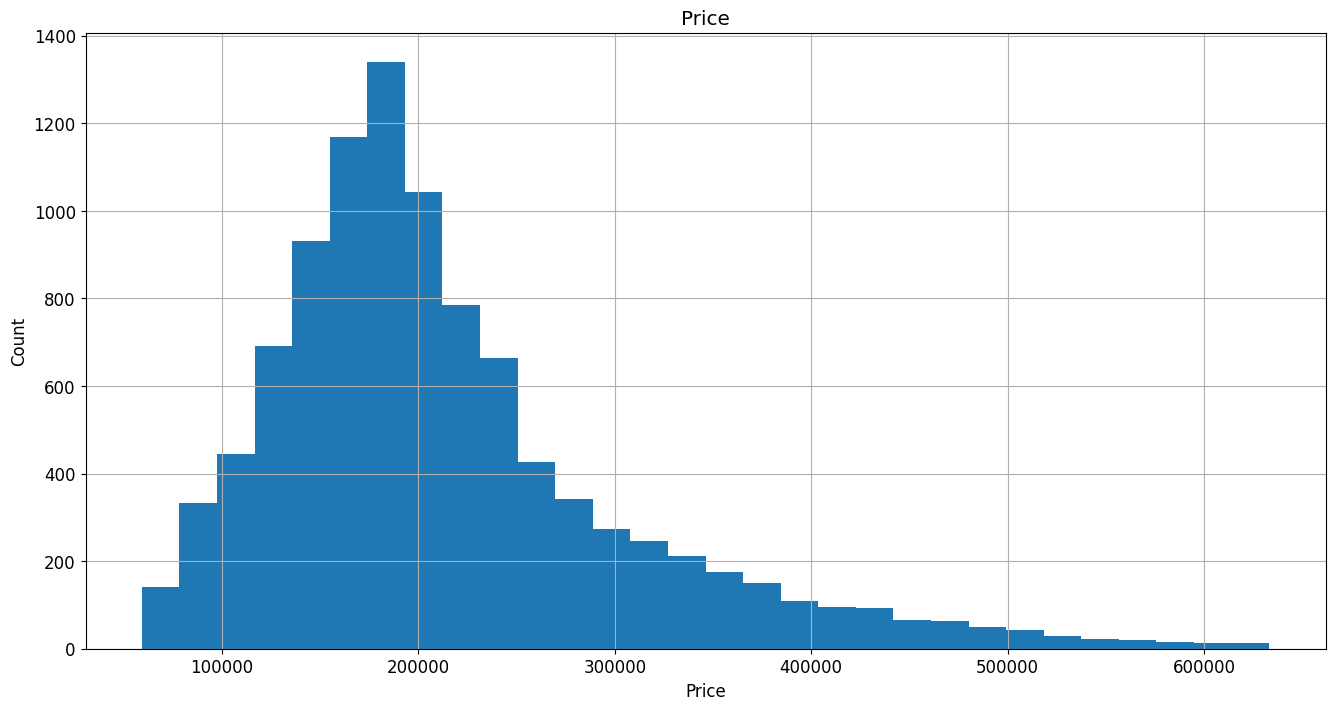

In [17]:
graph(train_df, 'Price', 30)

### Количественные переменные

In [18]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Номинативные переменные

In [19]:
train_df.dtypes

Id               category
DistrictId       category
Rooms                int8
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor           int8
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [20]:
train_df.select_dtypes(include='category').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [21]:
train_df['DistrictId'].value_counts()

DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
209      1
174      1
199      1
Name: count, Length: 205, dtype: int64

In [22]:
train_df['Ecology_2'].value_counts()

Ecology_2
B    9903
A      97
Name: count, dtype: int64

In [23]:
train_df['Ecology_3'].value_counts()

Ecology_3
B    9725
A     275
Name: count, dtype: int64

In [24]:
train_df['Shops_2'].value_counts()

Shops_2
B    9175
A     825
Name: count, dtype: int64

### Обработка выбросов и заполнение NAN

#### *Смотрим поле Square*

In [25]:
train_df[['Square']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Square  10000 non-null  float32
dtypes: float32(1)
memory usage: 39.2 KB


In [26]:
train_df['Square'].describe()

count    10000.000000
mean        56.315777
std         21.058731
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

In [27]:
train_df['Square'].value_counts(bins=10)

Square
(0.496, 65.13]        7350
(65.13, 129.123]      2596
(129.123, 193.115]      47
(193.115, 257.108]       3
(577.072, 641.065]       2
(257.108, 321.101]       1
(385.094, 449.087]       1
(321.101, 385.094]       0
(449.087, 513.08]        0
(513.08, 577.072]        0
Name: count, dtype: int64

In [28]:
SQUARE_MAX = 300
SQUARE_MIN = 10
KOEF_LIFE = 0.8

In [29]:
train_df[train_df['Square'] > SQUARE_MAX]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,28,9,2,604.705994,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.250000
4690,2307,102,1,409.425171,410.639740,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
6977,11602,30,2,641.065186,638.163208,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500


In [30]:
train_df['Square_outlier'] = 0
train_df['LifeSquare_outlier'] = 0
train_df.loc[(train_df['Square'] > SQUARE_MAX), 'Square_outlier'] = 1
train_df.loc[(train_df['Square'] > SQUARE_MAX), 'LifeSquare_outlier'] = 1
train_df.loc[(train_df['Square'] > SQUARE_MAX), 'Square'] = train_df['Square']/10 # делим выбросы на 10, т.к. похоже, что шиблись в запятой
train_df.loc[(train_df['Square'] > SQUARE_MAX), 'LifeSquare'] = train_df['LifeSquare']/10

In [31]:
train_df[train_df['Square'] > 200] # оставим как есть, такие квартиры могут быть

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250,0,0
1982,5548,86,5,275.645294,233.949310,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.875,0,0
9910,16568,27,4,200.334534,201.627365,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.500,0,0


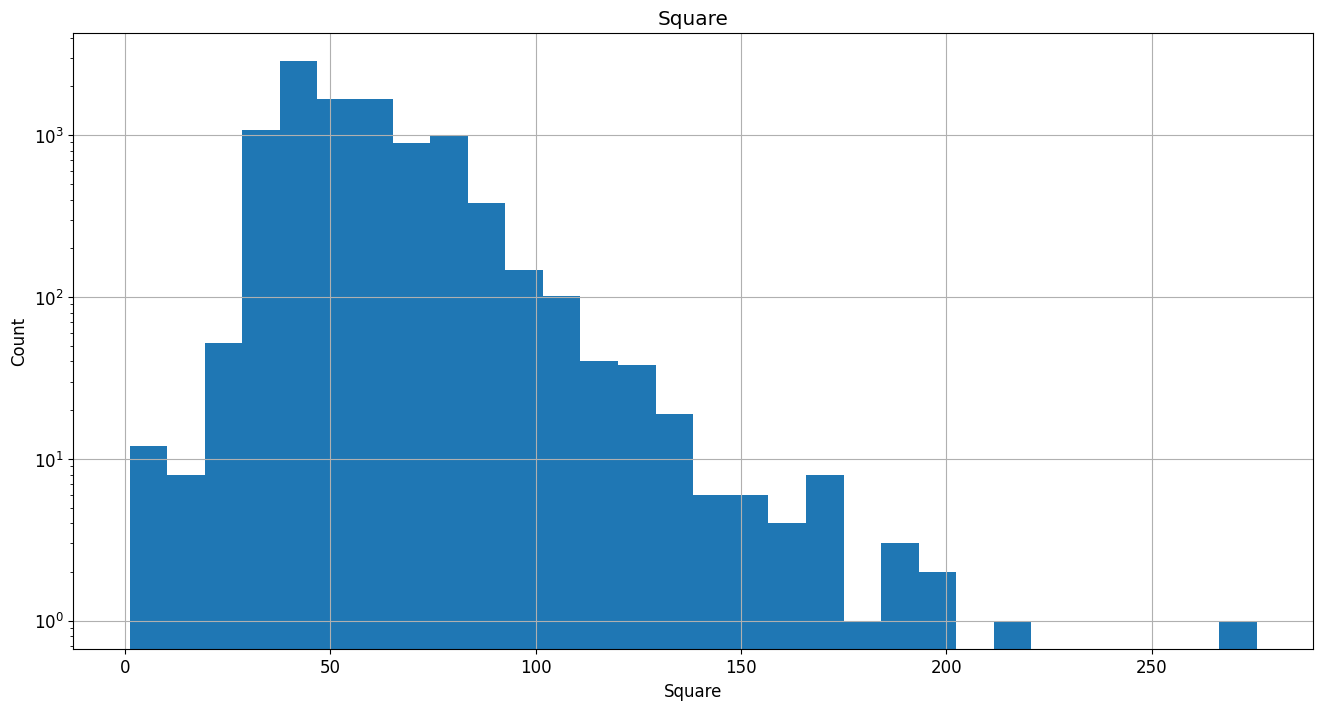

In [32]:
graph_log(train_df, 'Square', 30)

In [33]:
train_df['Square'].quantile(.99) # обрубать по этой квантили не стоит, квартир больше 117 м2 достаточно много

117.3741809082032

In [34]:
quant_025 = train_df['Square'].quantile(.025) # Факт - такие квартиры бывают.
quant_025

32.10518369674683

In [35]:
train_df[(train_df['Square'] < SQUARE_MIN)] # малореальный размер квартир

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier
212,1748,88,2,5.497061,67.628716,1.0,24,22,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.093750,0,0
1316,11526,27,1,4.633498,1.969969,1.0,18,1,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.265625,0,0
1608,10202,6,1,2.596351,4.604943,1.0,3,25,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.593750,0,0
3280,10527,27,1,4.380726,40.805836,1.0,10,17,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.718750,0,0
3413,9487,5,1,5.129221,5.549458,1.0,1,1,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.406250,0,0
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312,0,0
4900,4504,27,3,4.390331,5.610772,1.0,8,19,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.062500,0,0
6392,14786,1,1,1.136859,4.525736,1.0,3,1,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.828125,0,0
8030,13265,1,3,4.823679,79.767967,0.0,6,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.687500,0,0
8283,15744,34,1,1.988943,2.642219,1.0,21,4,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.781250,0,0


In [36]:
train_df.loc[(train_df['Square'] < SQUARE_MIN), 'Square_outlier'] = 1
train_df.loc[(train_df['Square'] < SQUARE_MIN), 'Square'] = train_df['Square']*10 # умножим выбросы на 10, т.к. похоже, что шиблись в запятой
train_df.loc[(train_df['Square'] < SQUARE_MIN), 'Square'] = train_df['Square']*10 # на всякий случай

In [37]:
train_df[(train_df['Square'] < quant_025) & (train_df['Rooms'] > 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier
4739,12676,81,3,13.784864,15.988890,7.0,4,5,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.804688,0,0
5617,15877,57,3,16.547241,16.698570,8.0,5,5,1962,0.133215,B,B,49,11395,3,1406.0,3,4,A,77835.187500,0,0
5667,4352,104,2,28.517666,15.565872,3.0,7,6,1931,0.000078,B,B,22,6398,141,1046.0,3,23,B,197245.265625,0,0
6945,12927,62,2,17.414181,NaN,1.0,4,20,1977,0.072158,B,B,2,629,1,NaN,0,0,A,180750.468750,0,0
8148,3052,1,3,31.113951,19.799744,6.0,6,5,1975,0.014581,B,B,3,760,1,NaN,0,0,B,114756.609375,0,0


In [38]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Square'] < quant_025) & (train_df['Rooms'] > 1), 'Rooms_outlier'] = 1
# Скорректируем кол-во комнат в квартирах < 32 м
train_df.loc[(train_df['Square'] < quant_025) & (train_df['Rooms'] > 1), 'Rooms'] = 1

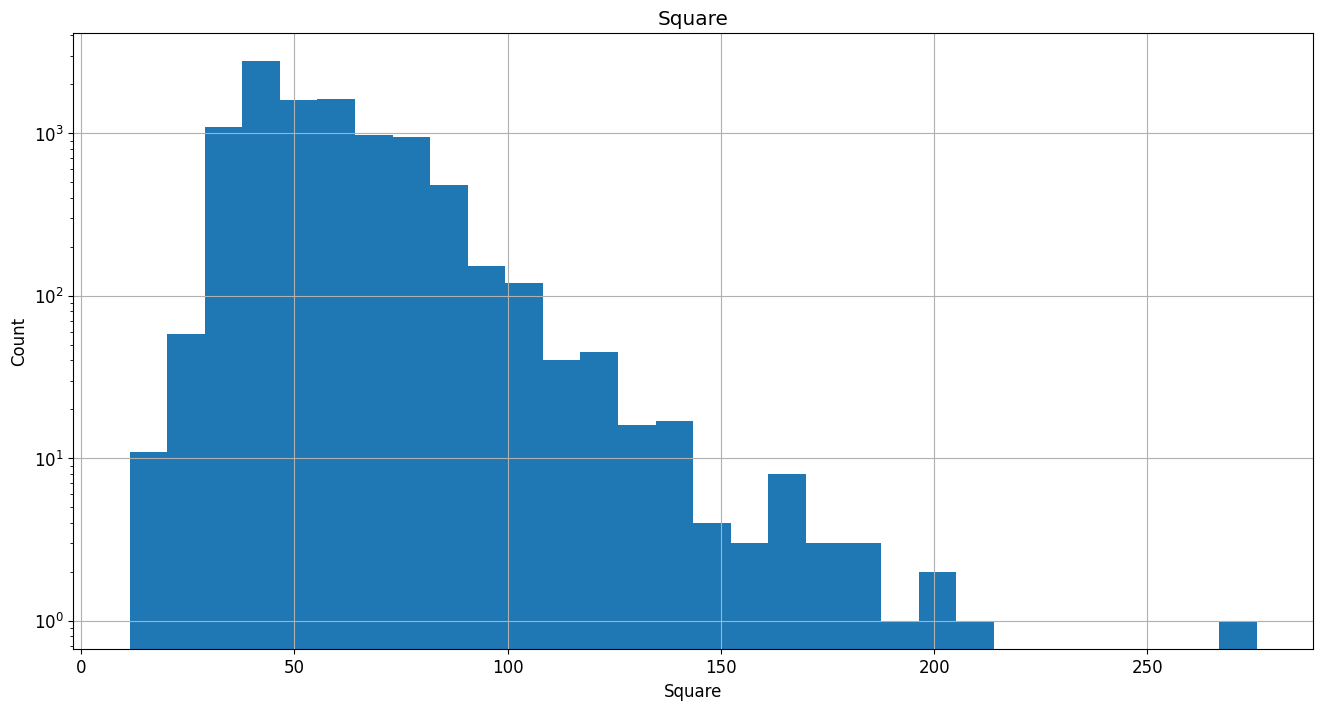

In [39]:
graph_log(train_df, 'Square', 30)

#### *Смотрим критерий LifeSquare*

In [40]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199646
std        86.241211
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

In [41]:
train_df.loc[(train_df['LifeSquare'] > SQUARE_MAX*KOEF_LIFE)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier
590,14990,23,2,48.449875,263.542023,5.0,6,5,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.234375,0,0,0
4328,16550,27,3,81.694420,7480.592285,1.0,9,17,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.500000,0,0,0
4690,2307,102,1,40.942516,410.639740,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688,1,1,0
6977,11602,30,2,64.106522,638.163208,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500,1,1,0
8437,15886,85,3,78.059334,461.463623,10.0,12,16,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.312500,0,0,0


In [42]:
train_df.loc[(train_df['LifeSquare'] > SQUARE_MAX*KOEF_LIFE), 'LifeSquare_outlier'] = 1
train_df.loc[(train_df['LifeSquare'] > SQUARE_MAX*KOEF_LIFE), 'LifeSquare'] = train_df['LifeSquare']/10 #делим выбросы на 10, т.к. похоже, что шиблись в запятой
train_df.loc[(train_df['LifeSquare'] > SQUARE_MAX*KOEF_LIFE), 'LifeSquare'] = train_df['LifeSquare']/10

In [43]:
train_df['LifeSquare'].value_counts(bins=6)

LifeSquare
(0.136, 39.3]        5120
(39.3, 78.23]        2519
(78.23, 117.16]       222
(117.16, 156.09]       17
(156.09, 195.02]        6
(195.02, 233.949]       3
Name: count, dtype: int64

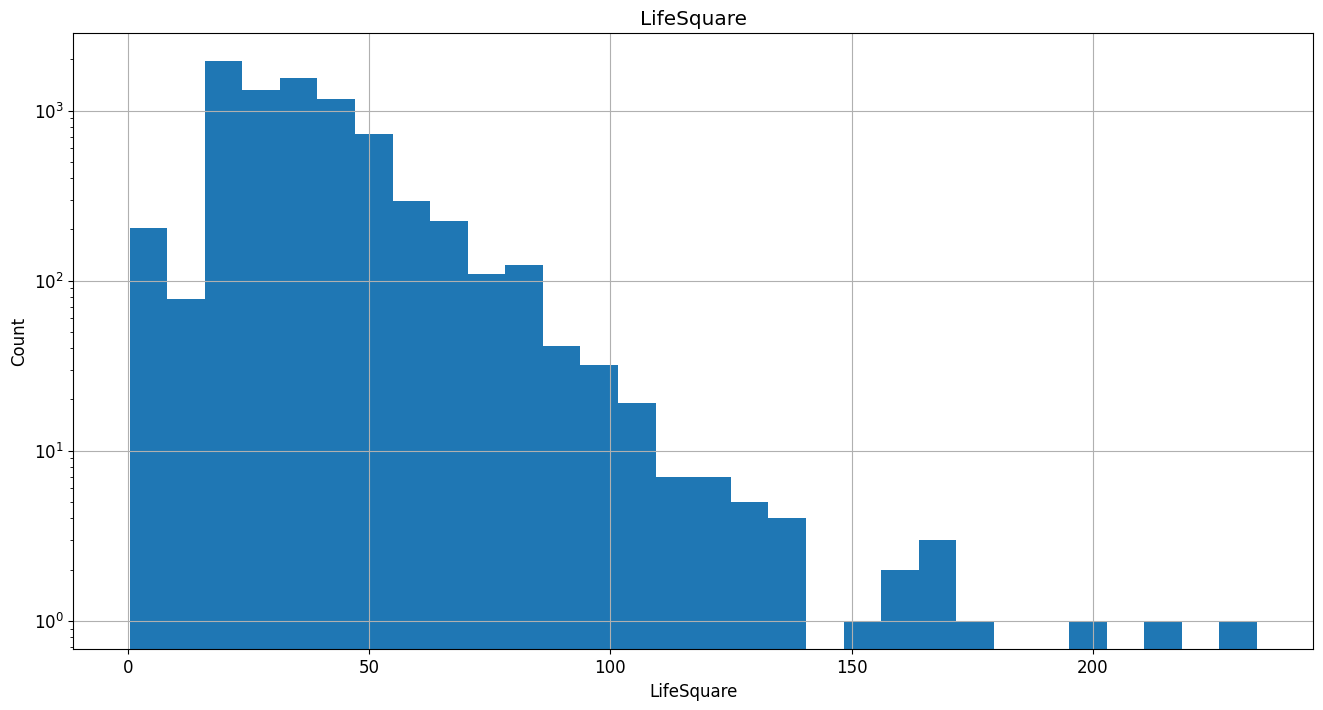

In [44]:
#визуализируем
graph_log(train_df, 'LifeSquare', 30)

In [45]:
train_df[(train_df['LifeSquare'] < SQUARE_MIN*KOEF_LIFE)] # малореальный размер жилой площади

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier
26,4378,27,3,106.958870,0.641822,0.0,17,0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.875000,0,0,0
95,4280,34,2,61.334969,4.091945,1.0,26,1,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.437500,0,0,0
134,12613,6,2,65.496674,5.589324,1.0,5,17,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.640625,0,0,0
158,16779,27,3,51.991066,4.896202,1.0,22,25,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.562500,0,0,0
160,3522,6,1,66.419838,3.987101,1.0,2,1,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.234375,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,13583,27,2,58.943039,3.319486,1.0,11,17,2017,0.011654,B,B,4,915,0,NaN,0,0,B,142789.953125,0,0,0
9813,2040,62,1,122.438148,5.751401,1.0,2,3,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.890625,0,0,0
9828,13630,24,3,127.141144,4.811405,1.0,3,1,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.937500,0,0,0
9888,6053,6,1,41.314774,5.005477,1.0,9,17,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515625,0,0,0


In [46]:
train_df.loc[(train_df['LifeSquare'] < SQUARE_MIN*KOEF_LIFE), 'LifeSquare_outlier'] = 1
train_df.loc[(train_df['LifeSquare'] < SQUARE_MIN*KOEF_LIFE), 'LifeSquare'] = train_df['LifeSquare']*10 # умножим выбросы на 10, т.к. похоже, что шиблись в запятой

In [47]:
train_df[(train_df['LifeSquare'] < SQUARE_MIN*KOEF_LIFE)] # проверим ещё раз

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier
26,4378,27,3,106.958870,6.418221,0.0,17,0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.875000,0,1,0
6609,13491,0,1,38.178276,3.706194,0.0,19,17,2016,0.006076,B,B,30,5285,0,645.0,6,6,B,105134.289062,0,1,0
9602,5112,6,2,63.591740,7.955394,10.0,17,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174742.000000,0,1,0


In [48]:
train_df.loc[(train_df['LifeSquare'] < SQUARE_MIN*KOEF_LIFE), 'LifeSquare'] = train_df['LifeSquare']*10

In [49]:
train_df['LifeSquare'].quantile(.99) # обрубать по этой квантили не стоит, квартир больше 95 м2 достаточно много

94.90142

In [50]:
quant_025 = train_df['LifeSquare'].quantile(.025)
quant_025

17.370295

In [51]:
train_df[train_df['LifeSquare'] > train_df['Square']] # Жилая площадь больше площади квартиры

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier
28,8054,23,1,42.530045,43.967758,1.0,3,9,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.195312,0,0,0
44,10521,38,3,104.211395,106.340401,0.0,20,0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.062500,0,0,0
52,2301,1,2,61.400055,65.224602,0.0,17,22,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.453125,0,0,0
123,8753,25,3,85.952309,89.803749,1.0,4,3,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.593750,0,0,0
153,9870,62,1,51.831474,53.491302,1.0,5,1,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.468750,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,6053,6,1,41.314774,50.054775,1.0,9,17,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515625,0,1,0
9889,12918,23,2,51.440464,53.134243,51.0,3,17,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.015625,0,0,0
9895,2737,27,3,123.430069,125.806984,123.0,5,10,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.843750,0,0,0
9902,14001,73,1,44.098766,44.267551,1.0,7,24,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.406250,0,0,0


Меняем их местами

In [52]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square']), 'Square_outlier'] = 1
train_df.loc[(train_df['LifeSquare'] > train_df['Square']), 'LifeSquare_outlier'] = 1
train_df['temporarily'] = train_df['Square']
train_df.loc[(train_df['LifeSquare'] > train_df['Square']), 'Square'] = train_df['LifeSquare']
train_df.loc[(train_df['LifeSquare'] > train_df['temporarily']), 'LifeSquare'] = train_df['temporarily']

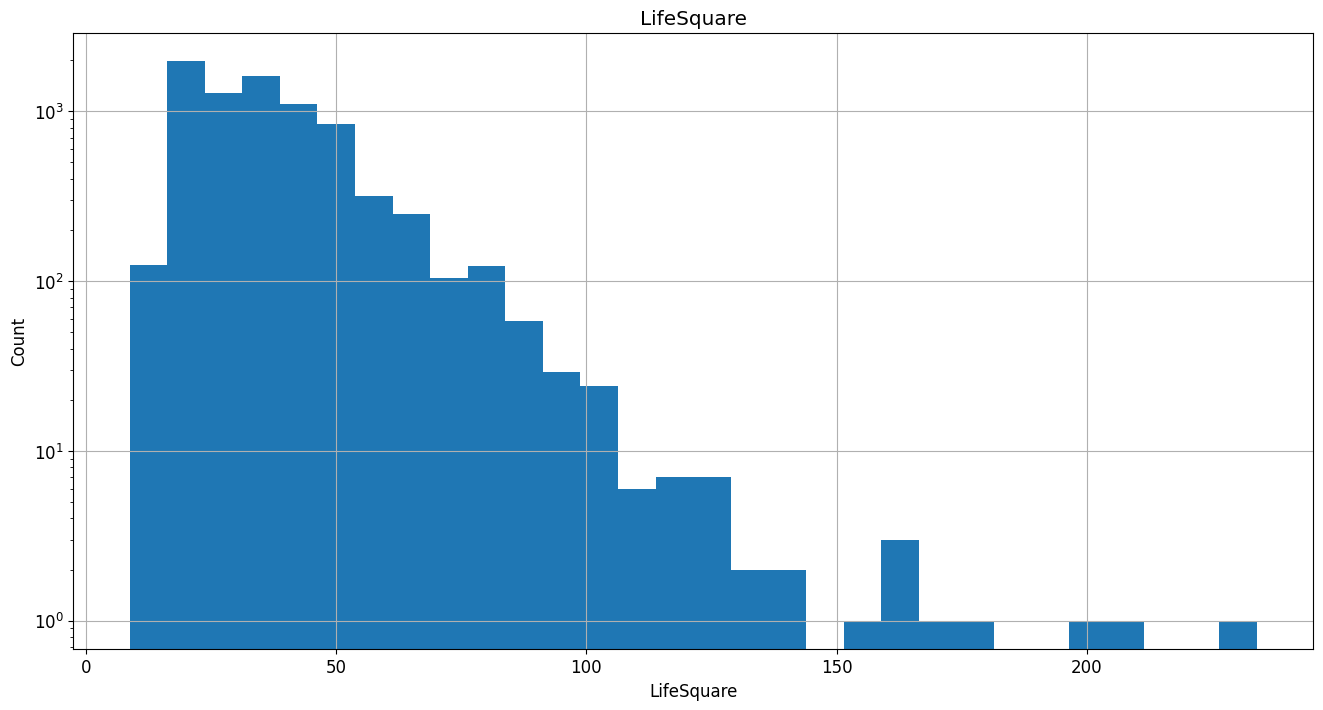

In [53]:
#визуализируем
graph_log(train_df, 'LifeSquare', 30)

Заполним пустые значения

In [54]:
train_df[pd.isnull(train_df['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily
7,11993,74,2,80.312927,NaN,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250,0,0,0,80.312927
8,5172,1,2,64.511436,NaN,1.0,9,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875,0,0,0,64.511436
21,11935,27,2,64.711838,NaN,1.0,15,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.023438,0,0,0,64.711838
23,6641,54,3,118.907608,NaN,0.0,2,0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.062500,0,0,0,118.907608
25,5073,74,2,82.667915,NaN,1.0,16,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,244145.828125,0,0,0,82.667915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1,38.968338,NaN,1.0,10,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312,0,0,0,38.968338
9986,2996,1,2,64.994247,NaN,1.0,9,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.515625,0,0,0,64.994247
9987,15623,23,2,55.620090,NaN,0.0,2,4,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.554688,0,0,0,55.620090
9994,4158,23,2,64.864197,NaN,1.0,17,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515625,0,0,0,64.864197


In [55]:
train_df.loc[pd.isnull(train_df['LifeSquare']), 'LifeSquare_outlier'] = 1
train_df.loc[pd.isnull(train_df['LifeSquare']), 'LifeSquare'] = train_df['Square']*KOEF_LIFE

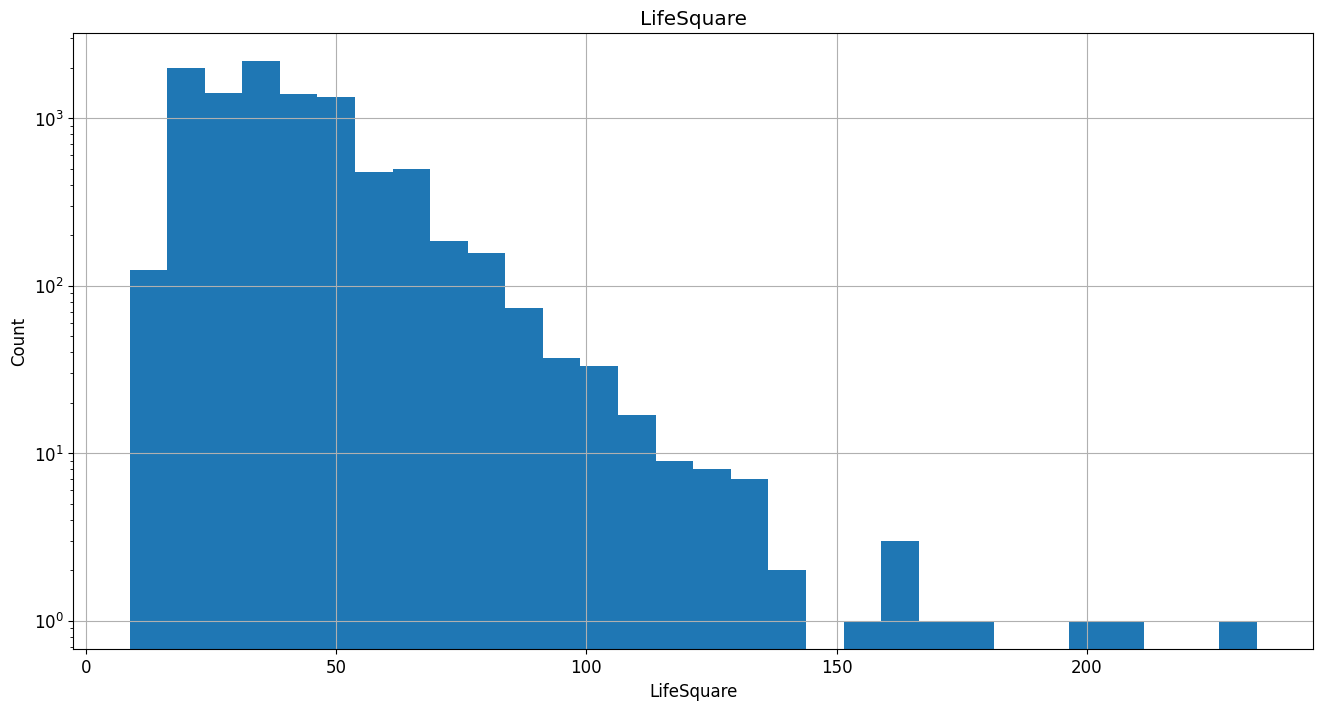

In [56]:
graph_log(train_df, 'LifeSquare', 30)

#### Смотрим поле Rooms

In [57]:
train_df['Rooms'].describe()

count    10000.000000
mean         1.889700
std          0.839526
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [58]:
train_df['Rooms'].value_counts()

Rooms
2     3878
1     3710
3     2232
4      150
5       18
0        8
10       2
19       1
6        1
Name: count, dtype: int64

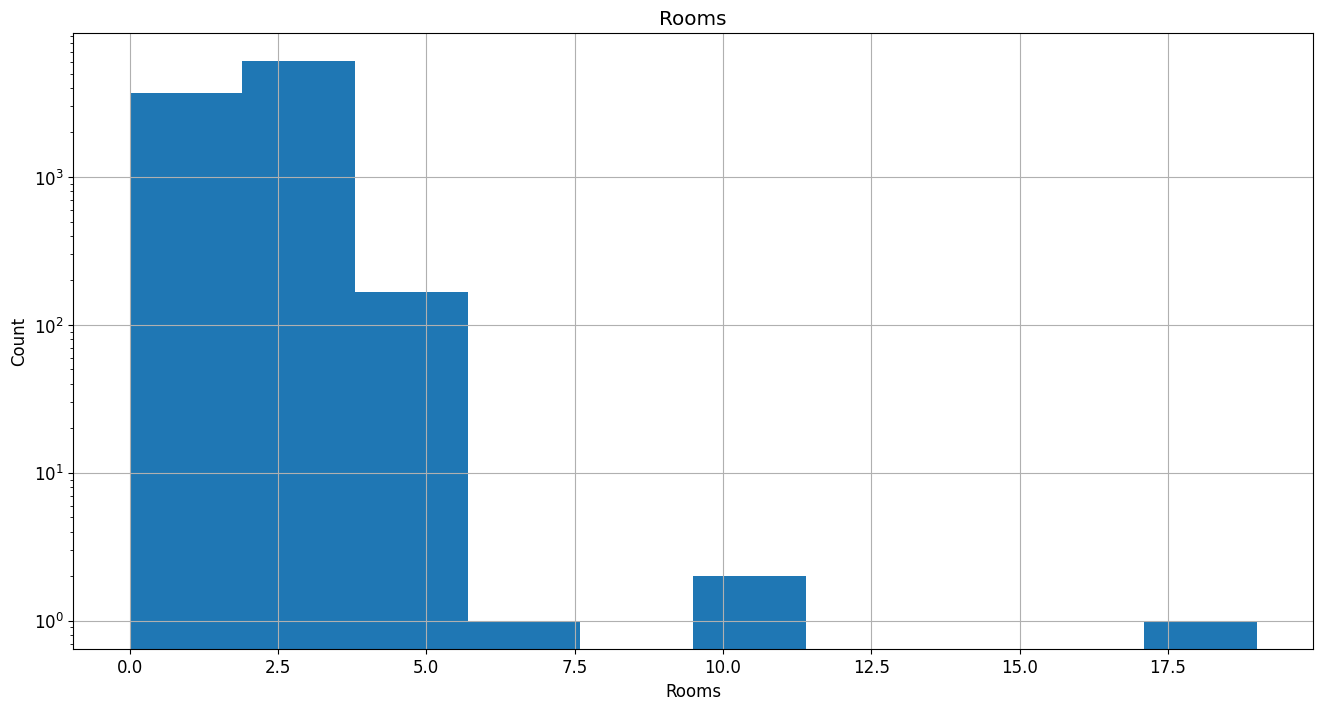

In [59]:
#визуализируем
graph_log(train_df, 'Rooms', 10)

In [60]:
train_df.loc[(train_df['Rooms'] <= 0) | (train_df['Rooms'] > 5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily
377,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500,0,0,0,59.056976
1397,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000,0,0,0,138.427689
1454,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188,0,0,0,42.006046
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000,0,0,0,212.932358
2170,14003,99,6,59.414333,38.702244,6.0,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750,0,0,0,59.414333
2269,7317,27,0,41.790882,33.432705,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562,0,1,0,41.790882
3911,770,28,0,49.483501,39.586803,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750,0,1,0,49.483501
4366,456,6,0,81.491447,65.193161,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875,0,1,0,81.491447
4853,3224,27,0,23.772476,8.731467,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312,1,1,0,23.772476
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375,0,0,0,38.697117


In [61]:
train_df.loc[(train_df['Rooms'] <= 0) | (train_df['Rooms'] > 5), 'Rooms_outlier'] = 1

In [62]:
train_df.loc[(train_df['Rooms'] > 5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily
377,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500,0,0,1,59.056976
1454,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188,0,0,1,42.006046
2170,14003,99,6,59.414333,38.702244,6.0,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750,0,0,1,59.414333
8849,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625,0,0,1,60.871265


Можно предположить, что  при двузначном количестве комнат вторая цыфра просто лишняя. Тогда получатся довольно большие однокомнатные. Однако раз для других квартир будем считать среднее по диапазону количество комнат, то и для двузначных значений поступим так же.

Смотрим как скорректировать ['Rooms'] == 0

In [63]:
train_df[(train_df['Rooms'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily
1397,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000,0,0,1,138.427689
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000,0,0,1,212.932358
2269,7317,27,0,41.790882,33.432705,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562,0,1,1,41.790882
3911,770,28,0,49.483501,39.586803,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750,0,1,1,49.483501
4366,456,6,0,81.491447,65.193161,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875,0,1,1,81.491447
4853,3224,27,0,23.772476,8.731467,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312,1,1,1,23.772476
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375,0,0,1,38.697117
8834,9443,27,0,87.762619,85.125473,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875,0,0,1,87.762619


Поступим аналогично тому, как поступили со слишком большим количеством комнат

In [64]:
# Пусть минимальная средняя площадь комнаты в квартире 10 м2
S_ROOM_MEAN = 10

In [65]:
# Тогда
train_df.loc[(train_df['Square'] < S_ROOM_MEAN * train_df['Rooms'] / KOEF_LIFE)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily
377,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500,0,0,1,59.056976
2170,14003,99,6,59.414333,38.702244,6.0,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750,0,0,1,59.414333
2247,16772,109,3,36.659412,32.795219,6.0,2,9,1979,0.136330,B,B,30,6141,10,262.0,3,6,B,173602.703125,1,1,0,32.795219
3271,6358,27,5,42.003292,33.602634,0.0,5,12,1977,0.011654,B,B,4,915,0,NaN,0,0,B,112693.640625,0,1,0,42.003292
4431,7594,53,5,39.906082,39.394024,1.0,5,1,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,206148.843750,0,0,0,39.906082
8551,13772,96,4,44.128948,18.212627,10.0,10,13,2005,0.041116,B,B,53,14892,4,NaN,1,4,B,201374.609375,0,0,0,44.128948
8849,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625,0,0,1,60.871265


Для таких площадей слишком много комнат<br>
Скорректируем количество комнат, аналогично их нулевому значению (объединяем условия)

In [66]:
train_df.loc[(train_df['Rooms'] <= 0) | (train_df['Rooms'] > 5) | (train_df['Square'] < S_ROOM_MEAN * train_df['Rooms'] / KOEF_LIFE), 'Rooms_outlier'] = 1

In [67]:
list_diapason = [SQUARE_MAX, 180, 110, 70, 45, SQUARE_MIN]
for i in range(len(list_diapason)-1):
    condition = round(train_df.loc[(train_df['Square'] <= list_diapason[i]) & (train_df['Square'] > list_diapason[i+1]) & (train_df['Rooms'] != 0) & (train_df['Rooms'] <= 5), 'Rooms'].mean())
    train_df.loc[(train_df['Square'] <= list_diapason[i]) & (train_df['Square'] > list_diapason[i+1]) & ((train_df['Rooms'] > 5) | (train_df['Rooms'] <= 0) | (train_df['Square'] < S_ROOM_MEAN * train_df['Rooms'] / KOEF_LIFE)), 'Rooms'] = condition

In [68]:
# смотрим, что получилось
train_df[train_df['Id'] == '7594']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily
4431,7594,53,1,39.906082,39.394024,1.0,5,1,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,206148.84375,0,0,1,39.906082


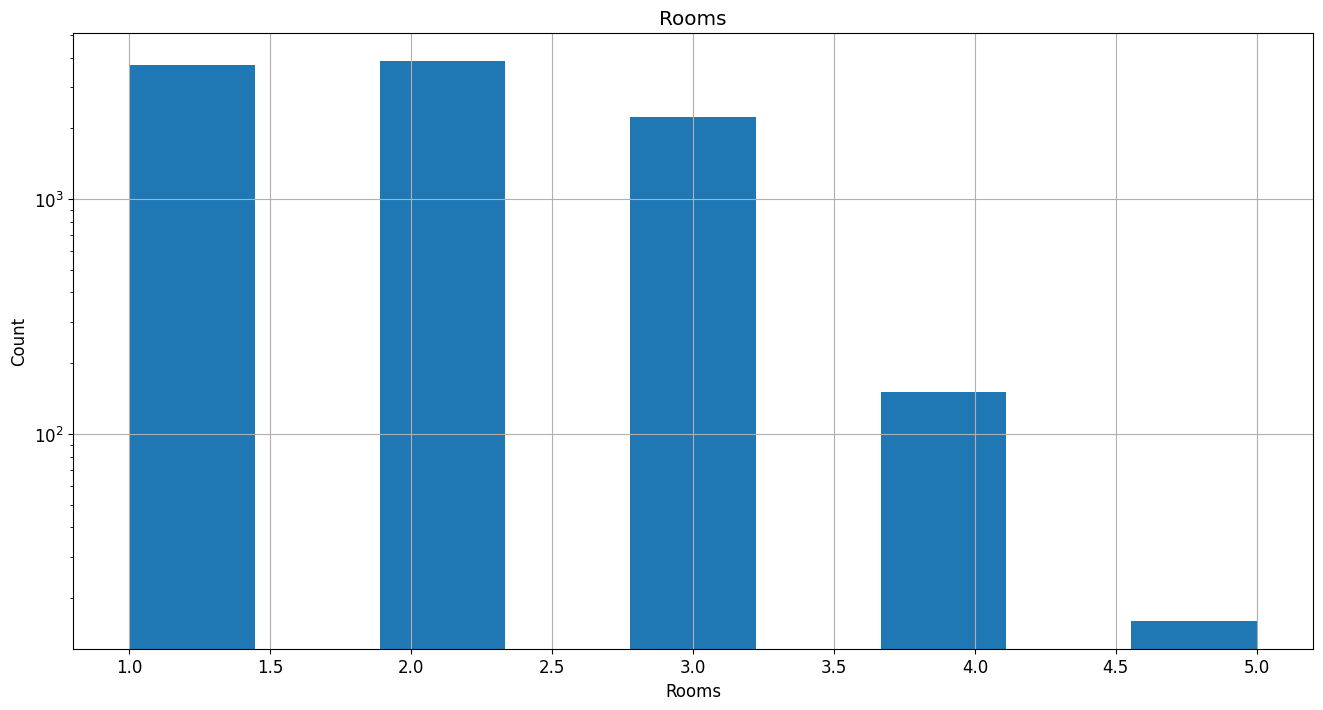

In [69]:
#визуализируем
graph_log(train_df, 'Rooms', 9)

In [70]:
train_df['Rooms'].value_counts()

Rooms
2    3882
1    3718
3    2234
4     150
5      16
Name: count, dtype: int64

#### *Смотрим критерий HouseYear*

In [71]:
train_df[['HouseYear']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   HouseYear  10000 non-null  int32
dtypes: int32(1)
memory usage: 39.2 KB


In [72]:
train_df['HouseYear'].value_counts()

HouseYear
1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
4968       1
1914       1
1916       1
1910       1
1928       1
Name: count, Length: 97, dtype: int64

In [73]:
train_df.loc[train_df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily
1497,10814,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250,0,0,0,37.265072
4189,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375,0,0,0,44.791836


In [74]:
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear_outlier'] = 1

In [75]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [76]:
train_df['HouseYear'].value_counts(bins=20)

HouseYear
(1976.0, 1981.5]                3103
(2014.5, 2020.0]                1185
(1970.5, 1976.0]                 979
(1965.0, 1970.5]                 833
(1959.5, 1965.0]                 828
(2003.5, 2009.0]                 566
(2009.0, 2014.5]                 556
(1981.5, 1987.0]                 538
(1992.5, 1998.0]                 390
(1998.0, 2003.5]                 374
(1987.0, 1992.5]                 356
(1954.0, 1959.5]                 171
(1948.5, 1954.0]                  44
(1932.0, 1937.5]                  24
(1937.5, 1943.0]                  19
(1926.5, 1932.0]                  15
(1915.5, 1921.0]                  12
(1909.8890000000001, 1915.5]       4
(1943.0, 1948.5]                   3
(1921.0, 1926.5]                   0
Name: count, dtype: int64

In [77]:
list_unique_HouseYear = train_df['HouseYear'].sort_values().unique()
list_unique_HouseYear

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int32)

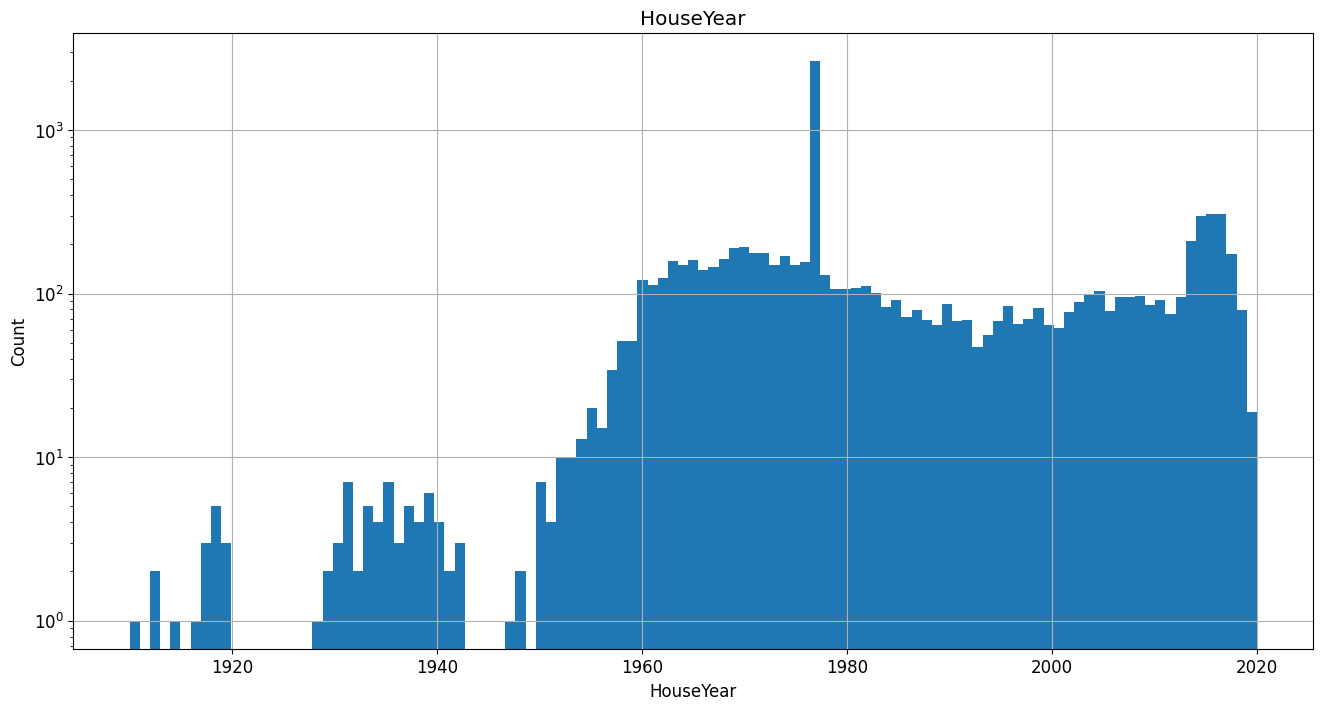

In [78]:
graph_log(train_df, 'HouseYear', 111)

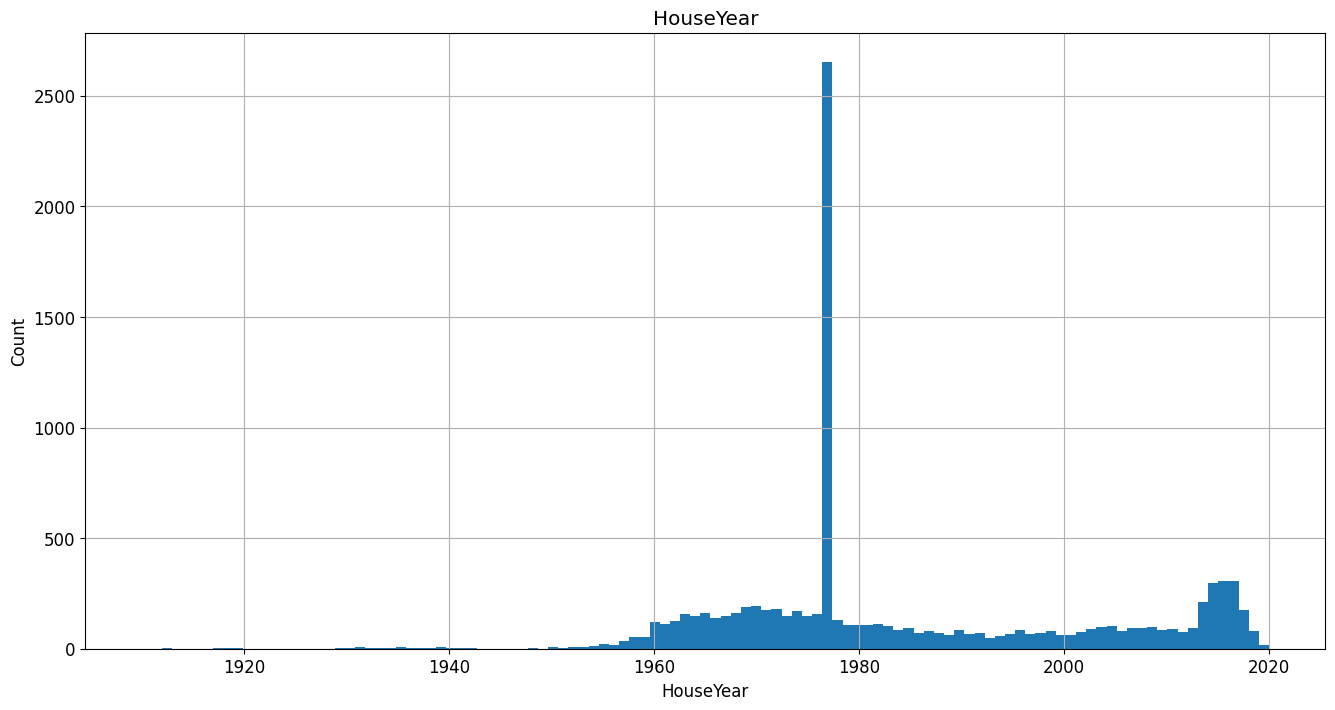

In [79]:
graph(train_df, 'HouseYear', 111)

Что-то не то с 1977 годом. Но что делать - информации нет никакой. Оставляем значение 1977, не считаем это за выброс

In [80]:
train_df[train_df['HouseYear'] == 1977]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375,0,0,0,53.352982,0
7,11993,74,2,80.312927,64.250343,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250,0,1,0,80.312927,0
8,5172,1,2,64.511436,51.609150,1.0,9,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875,0,1,0,64.511436,0
14,10953,27,1,53.769096,52.408028,1.0,5,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500,0,0,0,53.769096,0
21,11935,27,2,64.711838,51.769470,1.0,15,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.023438,0,1,0,64.711838,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,13352,77,2,53.537800,30.979053,8.0,10,12,1977,0.000070,B,B,46,10309,1,240.0,1,16,B,242356.406250,0,0,0,53.537800,0
9985,16159,27,1,38.968338,31.174671,1.0,10,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312,0,1,0,38.968338,0
9986,2996,1,2,64.994247,51.995399,1.0,9,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.515625,0,1,0,64.994247,0
9987,15623,23,2,55.620090,44.496075,0.0,2,4,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.554688,0,1,0,55.620090,0


#### *Смотрим признак KitchenSquare*

In [81]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [82]:
train_df.loc[train_df['KitchenSquare']>1900]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier
1064,14656,62,1,47.100719,46.447960,2014.0,4,1,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375,0,0,0,47.100719,0
8584,14679,81,1,32.276665,19.278395,1970.0,6,1,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688,0,0,0,32.276665,0


In [83]:
train_df['KitchenSquare_outlier'] = 0
train_df.loc[(train_df['KitchenSquare'] > 1900) & (train_df['KitchenSquare'] < train_df['HouseYear']), 'HouseYear_outlier'] = 1
train_df.loc[(train_df['KitchenSquare'] > 1900), 'KitchenSquare_outlier'] = 1
train_df.loc[(train_df['KitchenSquare'] > 1900) & (train_df['KitchenSquare'] < train_df['HouseYear']), 'HouseYear'] = train_df['KitchenSquare']

In [84]:
group = train_df.loc[(train_df['KitchenSquare']>5) & (train_df['KitchenSquare']<40)].groupby('HouseYear')
group = group['KitchenSquare'].median()
group[[2014, 1977]]

HouseYear
2014    10.0
1977     9.0
Name: KitchenSquare, dtype: float32

In [85]:
list_unique_HouseYear = list(list_unique_HouseYear)
group_min_max = train_df.loc[(train_df['KitchenSquare']<=5) | (train_df['KitchenSquare']>=40)].groupby('HouseYear')
group_min_max = group_min_max['KitchenSquare'].median()
for i in list_unique_HouseYear:
    if i not in list(group.index):
        group[i] = list(group_min_max[[i]])[0]

In [86]:
train_df['KitchenSquare_mean_in_year']=list(group[train_df['HouseYear']])

In [87]:
train_df.loc[(train_df['KitchenSquare']>1900), 'KitchenSquare'] = train_df['KitchenSquare_mean_in_year']

In [88]:
train_df['KitchenSquare'].value_counts()

KitchenSquare
1.0      2460
8.0      1306
5.0      1169
10.0     1076
6.0      1039
9.0       843
0.0       697
7.0       609
12.0      249
11.0      233
13.0       67
14.0       51
4.0        39
15.0       31
3.0        22
16.0       16
20.0       14
17.0       12
19.0       11
18.0        6
2.0         4
22.0        3
32.0        2
41.0        2
51.0        2
30.0        2
112.0       2
37.0        2
43.0        2
25.0        2
58.0        2
84.0        1
75.0        1
21.0        1
54.0        1
62.0        1
40.0        1
29.0        1
27.0        1
39.0        1
35.0        1
23.0        1
73.0        1
31.0        1
60.0        1
63.0        1
42.0        1
36.0        1
96.0        1
26.0        1
53.0        1
78.0        1
66.0        1
48.0        1
72.0        1
123.0       1
Name: count, dtype: int64

In [89]:
train_df.loc[train_df['KitchenSquare']>train_df['Square']] # площадь кухни больше площади квартиры

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year
5149,13703,42,1,38.071693,19.723547,73.0,9,10,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.031250,0,0,0,38.071693,0,0,10.0
7088,6569,27,1,38.220257,18.716856,84.0,4,17,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960938,0,0,0,38.220257,0,0,10.0


In [90]:
train_df.loc[(train_df['KitchenSquare']>train_df['Square']), 'KitchenSquare_outlier'] = 1
train_df.loc[(train_df['KitchenSquare']>train_df['Square']), 'KitchenSquare'] = train_df['KitchenSquare']/10 # поделим выбросы на 10, т.к. похоже, что шиблись в запятой
train_df.loc[(train_df['KitchenSquare']>train_df['Square']), 'KitchenSquare'] = train_df['KitchenSquare']/10 # на всякий случай
train_df['Studio'] = 0

Теперь надо разобраться с кухнями <=5 м**2.

In [91]:
train_df.loc[(train_df['KitchenSquare']<=5) & (train_df['Studio']==0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250,0,0,0,44.947952,0,0,7.0,0
7,11993,74,2,80.312927,64.250343,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250,0,1,0,80.312927,0,0,9.0,0
8,5172,1,2,64.511436,51.609150,1.0,9,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875,0,1,0,64.511436,0,0,9.0,0
12,6452,13,2,54.522804,31.759752,1.0,8,12,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.375000,0,0,0,54.522804,0,0,9.0,0
14,10953,27,1,53.769096,52.408028,1.0,5,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500,0,0,0,53.769096,0,0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987,15623,23,2,55.620090,44.496075,0.0,2,4,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.554688,0,1,0,55.620090,0,0,9.0,0
9990,15233,1,3,57.373890,39.688446,5.0,2,5,1962,0.036270,B,B,6,1318,1,200.0,1,1,B,163807.546875,0,0,0,57.373890,0,0,7.0,0
9994,4158,23,2,64.864197,51.891357,1.0,17,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515625,0,1,0,64.864197,0,0,9.0,0
9995,77,32,2,50.401787,30.476204,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500,0,0,0,50.401787,0,0,7.0,0


In [92]:
train_df.loc[(train_df['KitchenSquare']<=5) & (train_df['Studio']==0), 'KitchenSquare_outlier'] = 1

In [93]:
train_df.loc[(train_df['KitchenSquare']<=5) & (train_df['Studio']==0), 'KitchenSquare'] = train_df['KitchenSquare_mean_in_year']

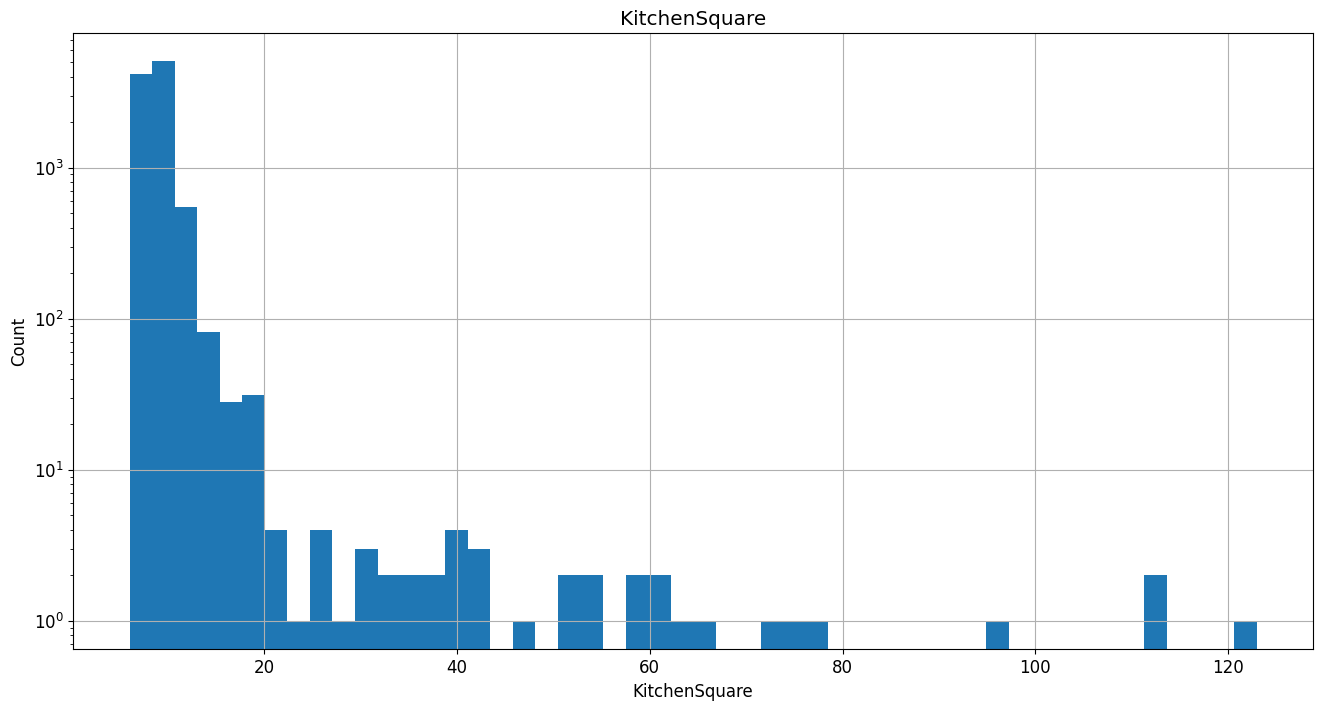

In [94]:
graph_log(train_df, 'KitchenSquare', 50)

In [95]:
train_df.loc[train_df['KitchenSquare']>45, 'KitchenSquare'] = train_df['KitchenSquare_mean_in_year']

In [96]:
train_df['KitchenSquare'].value_counts()

KitchenSquare
9.0     3149
10.0    1965
7.0     1419
8.0     1394
6.0     1350
12.0     250
11.0     233
13.0      68
14.0      51
15.0      31
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
22.0       3
41.0       2
25.0       2
30.0       2
37.0       2
43.0       2
32.0       2
21.0       1
27.0       1
8.4        1
6.5        1
40.0       1
29.0       1
23.0       1
35.0       1
7.3        1
31.0       1
9.5        1
42.0       1
36.0       1
11.5       1
26.0       1
39.0       1
Name: count, dtype: int64

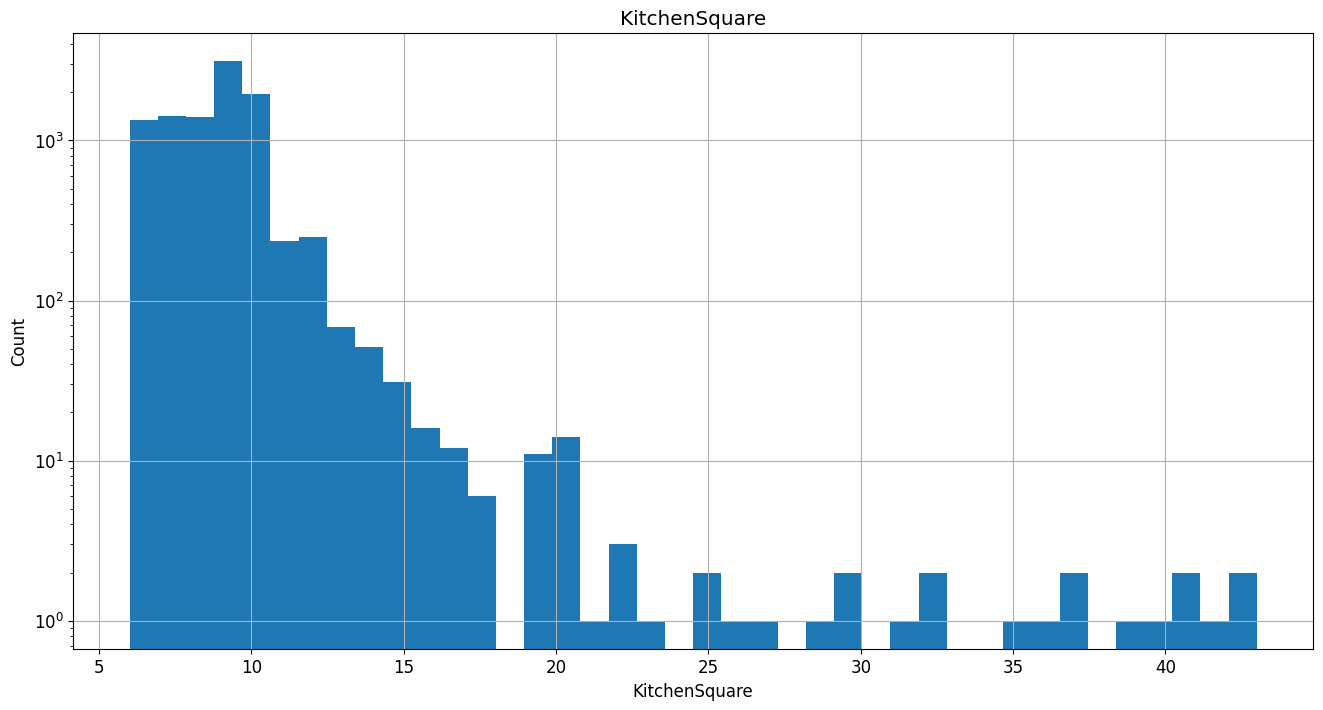

In [97]:
graph_log(train_df, 'KitchenSquare', 40)

#### *Смотрим Floor*

In [98]:
train_df[['Floor']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Floor   10000 non-null  int8 
dtypes: int8(1)
memory usage: 9.9 KB


In [99]:
train_df['Floor'].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [100]:
train_df['Floor'].value_counts()

Floor
4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
31      1
37      1
33      1
Name: count, dtype: int64

In [101]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

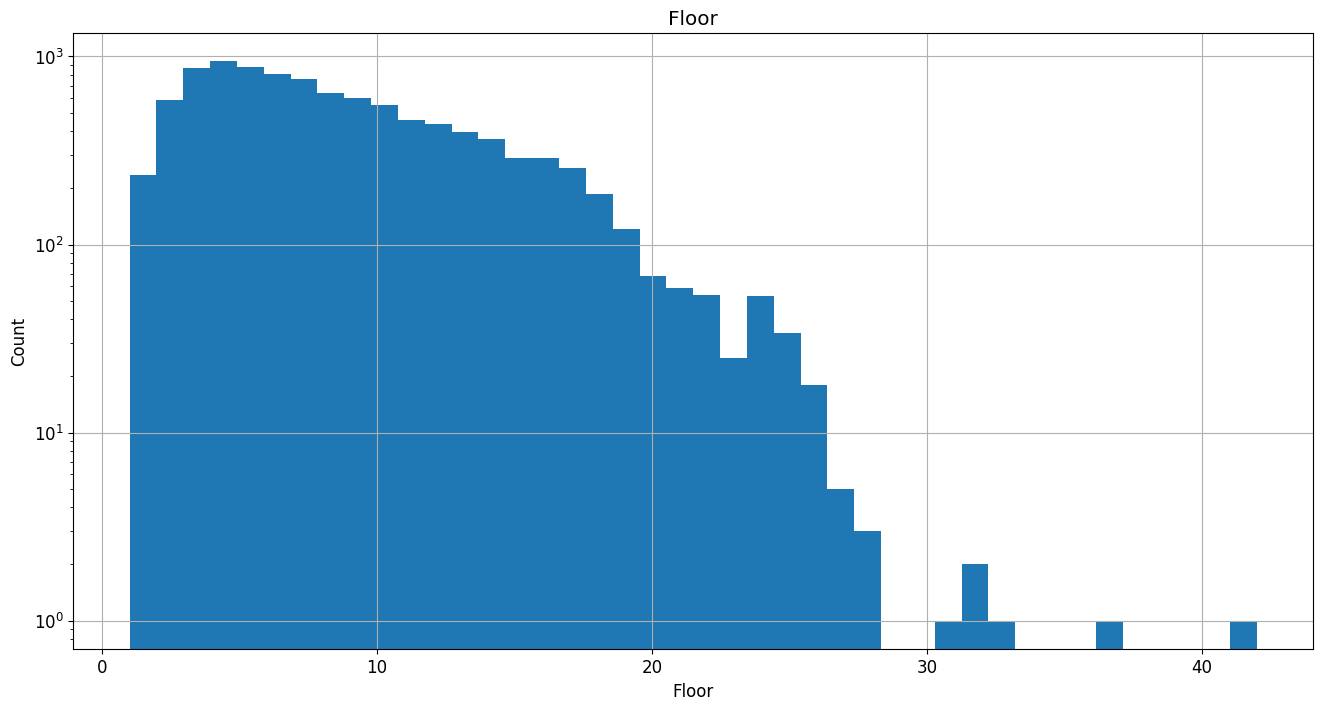

In [102]:
graph_log(train_df, 'Floor', 42)

In [103]:
train_df.loc[train_df['Floor']>30]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio
339,11563,8,1,50.390862,41.642899,10.0,32,32,2008,0.092291,B,B,21,4346,2,165.0,1,2,B,97480.843750,0,0,0,50.390862,0,1,10.0,0
2781,1674,76,2,74.344673,41.044132,10.0,42,48,2016,0.000000,B,B,7,1660,39,1786.0,1,5,B,411691.500000,0,0,0,74.344673,0,1,10.0,0
3330,3298,31,1,57.551693,21.551876,10.0,32,40,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,393799.531250,0,0,0,57.551693,0,0,9.0,0
4323,6589,30,1,62.110825,52.812126,9.0,31,44,2009,0.000078,B,B,22,6398,141,1046.0,3,23,B,117647.460938,0,0,0,62.110825,0,1,9.0,0
6755,8296,146,1,86.386757,71.904999,10.0,37,38,2012,0.236108,B,B,16,3893,27,NaN,3,10,B,269113.593750,0,0,0,86.386757,0,1,10.0,0
8357,8016,31,1,59.519897,24.050533,10.0,33,40,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,389554.062500,0,0,0,59.519897,0,0,9.0,0


Выбросами пока считать не буду, вероятно, какие-то высотки. Третья и шестая квартиры расположены в одном доме.

#### *Смотрим HouseFloor*

In [104]:
train_df['HouseFloor'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: HouseFloor
Non-Null Count  Dtype
--------------  -----
10000 non-null  int8 
dtypes: int8(1)
memory usage: 9.9 KB


In [105]:
train_df['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [106]:
train_df['HouseFloor'].value_counts()

HouseFloor
17     2331
9      1389
12     1074
5      1031
14      625
16      576
1       497
25      374
22      343
0       269
24      176
8       141
10      135
4       134
3       127
15      123
19      108
20      105
18       89
7        59
6        58
2        48
23       40
21       33
11       28
13       27
30       21
40        7
27        6
37        4
32        4
28        3
39        2
99        2
48        2
44        1
47        1
36        1
29        1
45        1
38        1
117       1
26        1
31        1
Name: count, dtype: int64

In [107]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int8)

In [108]:
train_df['HouseFloor'].value_counts(bins=20)

HouseFloor
(11.7, 17.55]                   4756
(-0.11800000000000001, 5.85]    2106
(5.85, 11.7]                    1810
(17.55, 23.4]                    718
(23.4, 29.25]                    561
(29.25, 35.1]                     26
(35.1, 40.95]                     15
(46.8, 52.65]                      3
(40.95, 46.8]                      2
(93.6, 99.45]                      2
(111.15, 117.0]                    1
(64.35, 70.2]                      0
(70.2, 76.05]                      0
(76.05, 81.9]                      0
(81.9, 87.75]                      0
(87.75, 93.6]                      0
(52.65, 58.5]                      0
(99.45, 105.3]                     0
(105.3, 111.15]                    0
(58.5, 64.35]                      0
Name: count, dtype: int64

In [109]:
train_df[train_df['HouseFloor']>50].sort_values('HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio
6131,10806,5,1,51.944588,48.709602,9.0,6,99,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.12500,0,0,0,51.944588,0,1,9.0,0
8599,9300,74,2,74.579811,71.747871,9.0,5,99,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.90625,1,1,0,71.747871,0,0,9.0,0
8854,78,30,2,66.811790,65.773750,9.0,8,117,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.37500,1,1,0,65.773750,0,1,9.0,0


In [110]:
train_df['Floor_outlier'] = 0
train_df['HouseFloor_outlier'] = 0

In [111]:
train_df.loc[train_df['HouseFloor']>50, 'HouseFloor_outlier'] = 1

In [112]:
train_df.loc[train_df['HouseFloor']==99, 'HouseFloor'] = 9
train_df.loc[train_df['HouseFloor']==117, 'HouseFloor'] = 17

In [113]:
train_df[train_df['HouseFloor']>30].sort_values('HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier
9332,8510,7,2,82.390289,40.316799,16.0,2,31,2013,0.035145,B,B,42,9292,3,2620.0,0,3,B,287326.125000,0,0,0,82.390289,0,0,10.0,0,0,0
8763,12642,8,1,49.235302,43.066601,10.0,14,32,2006,0.219006,B,B,28,6746,3,NaN,1,4,B,226498.468750,0,0,0,49.235302,0,1,10.0,0,0,0
8060,7763,29,2,74.478409,39.382328,11.0,3,32,2012,0.069660,B,B,31,6119,4,NaN,1,2,B,150745.625000,0,0,0,74.478409,0,0,10.0,0,0,0
4481,7789,146,1,60.890930,45.768513,11.0,13,32,2011,0.236108,B,B,16,3893,27,NaN,3,10,B,227510.031250,0,0,0,60.890930,0,0,10.0,0,0,0
339,11563,8,1,50.390862,41.642899,10.0,32,32,2008,0.092291,B,B,21,4346,2,165.0,1,2,B,97480.843750,0,0,0,50.390862,0,1,10.0,0,0,0
5452,11625,84,1,102.640236,78.746445,19.0,26,36,2012,0.006076,B,B,30,5285,0,645.0,6,6,B,342223.031250,0,0,0,102.640236,0,0,10.0,0,0,0
5270,6327,146,3,75.037086,45.811035,9.0,11,37,2010,0.236108,B,B,16,3893,27,NaN,3,10,B,288203.437500,0,0,0,75.037086,0,0,9.0,0,0,0
3662,1102,54,3,101.279846,52.188698,20.0,20,37,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,124844.929688,0,0,0,101.279846,0,0,10.0,0,0,0
1956,15157,54,1,106.239624,83.296165,17.0,26,37,2009,0.006076,B,B,30,5285,0,645.0,6,6,B,274139.062500,0,0,0,106.239624,0,0,9.0,0,0,0
1982,5548,86,5,275.645294,233.949310,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.875000,0,0,0,275.645294,0,0,10.0,0,0,0


In [114]:
# уберём этажи квартир выше 48 - считаем, что, скорее всего, там первая цифра случайно нажата (проверял для теста)
train_df.loc[(train_df['Floor'] > 48), 'Floor'] = train_df['Floor'] % 10

In [115]:
# этаж квартиры больше этажности дома
train_df.loc[(train_df['Floor'] > train_df['HouseFloor'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier
7,11993,74,2,80.312927,64.250343,9.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250,0,1,0,80.312927,0,1,9.0,0,0,0
14,10953,27,1,53.769096,52.408028,9.0,5,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500,0,0,0,53.769096,0,1,9.0,0,0,0
16,2119,27,2,49.360649,31.993963,8.0,6,5,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.382812,0,0,0,49.360649,0,1,8.0,0,0,0
21,11935,27,2,64.711838,51.769470,9.0,15,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.023438,0,1,0,64.711838,0,1,9.0,0,0,0
23,6641,54,3,118.907608,95.126091,9.0,2,0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.062500,0,1,0,118.907608,0,1,9.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3,64.074974,47.633427,6.0,11,9,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.875000,0,0,0,64.074974,0,0,8.0,0,0,0
9985,16159,27,1,38.968338,31.174671,9.0,10,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312,0,1,0,38.968338,0,1,9.0,0,0,0
9989,4145,96,3,90.055229,47.860229,11.0,26,24,2005,0.041116,B,B,53,14892,4,NaN,1,4,B,441108.906250,0,0,0,90.055229,0,0,10.0,0,0,0
9991,11553,3,3,101.622795,51.628780,12.0,18,17,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.500000,0,0,0,101.622795,0,0,10.0,0,0,0


In [116]:
train_df.loc[(train_df['HouseFloor'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier
7,11993,74,2,80.312927,64.250343,9.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.15625,0,1,0,80.312927,0,1,9.0,0,0,0
23,6641,54,3,118.907608,95.126091,9.0,2,0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.06250,0,1,0,118.907608,0,1,9.0,0,0,0
26,4378,27,3,106.958870,64.182213,10.0,17,0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.87500,0,1,0,106.958870,0,1,10.0,0,0,0
39,9371,23,2,60.503250,48.402599,9.0,16,0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.06250,0,1,0,60.503250,0,1,9.0,0,0,0
44,10521,38,3,106.340401,104.211395,10.0,20,0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.06250,1,1,0,104.211395,0,1,10.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1,48.307846,46.072914,9.0,4,0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.09375,1,1,0,46.072914,0,1,9.0,0,0,0
9769,9384,59,3,98.607330,78.885864,9.0,14,0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.25000,0,1,0,98.607330,0,1,9.0,0,0,0
9878,11441,62,2,72.453232,71.985336,9.0,5,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,158841.62500,1,1,0,71.985336,0,1,9.0,0,0,0
9908,3171,62,1,35.873962,28.699171,9.0,25,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,134379.12500,0,1,0,35.873962,0,1,9.0,0,0,0


In [117]:
train_df['HouseFloor'].mode()[0]

17

Домам с нулевой этажностью назначим самую часто встречающуюся этажность.<br>
Но сначала обработаем дома с ненулевой этажностью.

In [118]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] == 1), 'HouseFloor'].count()

484

In [119]:
train_df.loc[(train_df['HouseFloor'] == 1), 'HouseFloor'].count()

497

In [120]:
train_df.loc[(train_df['Floor'] == 1), 'HouseFloor'].count()

235

In [121]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] == 5), 'HouseFloor'].count()

242

In [122]:
train_df.loc[(train_df['HouseFloor'] == 5), 'HouseFloor'].count()

1031

In [123]:
train_df.loc[(train_df['Floor'] == 5), 'HouseFloor'].count()

876

Предположу, что перепутаны данные по этажу и этажности дома. Поменяем их местами.

In [124]:
train_df.loc[(train_df['HouseFloor'] < train_df['Floor'] & (train_df['HouseFloor'] != 0)), 'Floor_outlier'] = 1
train_df.loc[(train_df['HouseFloor'] < train_df['Floor']), 'HouseFloor_outlier'] = 1
train_df['temporarily'] = train_df['Floor']
train_df.loc[(train_df['HouseFloor'] < train_df['Floor']) & (train_df['HouseFloor'] != 0), 'Floor'] = train_df['HouseFloor']
train_df.loc[(train_df['HouseFloor'] < train_df['temporarily']) & (train_df['HouseFloor'] != 0), 'HouseFloor'] = train_df['temporarily']

Теперь домам с нулевой этажностью назначим самую часто встречающуюся этажность.<br>

In [125]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [126]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier
44,10521,38,3,106.340401,104.211395,10.0,20,17,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.062500,1,1,0,20,0,1,10.0,0,0,1
501,15923,27,1,26.553188,21.242552,9.0,25,17,1977,0.072158,B,B,2,629,1,NaN,0,0,A,114256.234375,0,1,0,25,0,1,9.0,0,0,1
594,8093,45,2,62.933064,50.346451,9.0,18,17,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,339455.281250,0,1,0,18,0,1,9.0,0,0,1
900,8940,34,1,26.811586,21.449270,9.0,18,17,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,175399.640625,0,1,0,18,0,1,9.0,0,0,1
1493,11388,27,3,46.923653,37.538921,9.0,24,17,1977,0.072158,B,B,2,629,1,NaN,0,0,A,149404.828125,0,1,0,24,0,1,9.0,0,0,1
1620,13162,6,1,39.324207,31.459366,9.0,22,17,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,132023.093750,0,1,0,22,0,1,9.0,0,0,1
1759,13644,25,3,82.816200,66.252960,9.0,19,17,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,317960.343750,0,1,0,19,0,1,9.0,0,0,1
2205,11960,34,1,38.232838,35.143078,10.0,19,17,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,190443.718750,0,0,0,19,0,0,9.0,0,0,1
2771,2209,62,1,38.996521,31.197218,9.0,23,17,1977,0.072158,B,B,2,629,1,NaN,0,0,A,125977.312500,0,1,0,23,0,1,9.0,0,0,1
3915,7198,48,2,81.452950,80.294113,9.0,21,17,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,448076.468750,1,1,0,21,0,1,9.0,0,0,1


У квартир, этаж которых выше этажности дома, приравняем этажность к этажу квартиры.

In [127]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor'] = train_df['Floor']

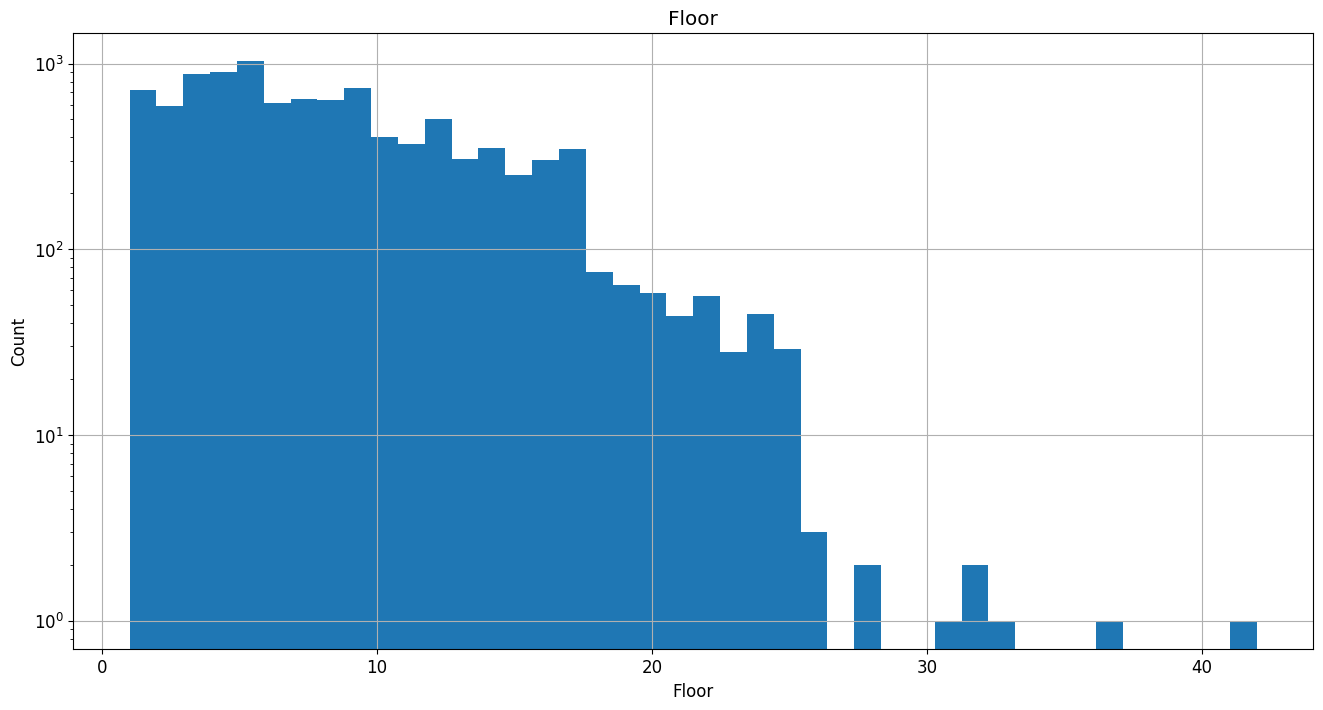

In [128]:
graph_log(train_df, 'Floor', 42)

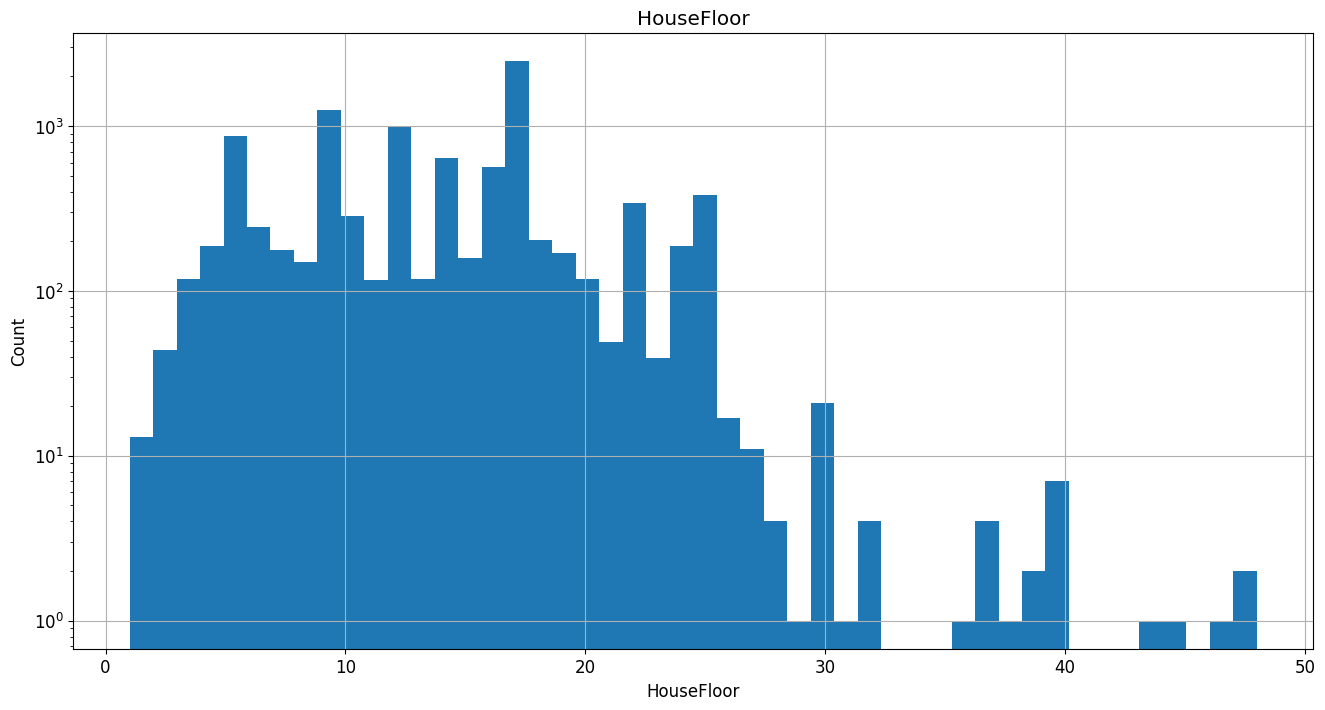

In [129]:
graph_log(train_df, 'HouseFloor', 48)

#### *Смотрим Ecology_1*

In [130]:
train_df[['Ecology_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ecology_1  10000 non-null  float32
dtypes: float32(1)
memory usage: 39.2 KB


In [131]:
train_df['Ecology_1'].describe()

count    10000.000000
mean         0.118858
std          0.119025
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

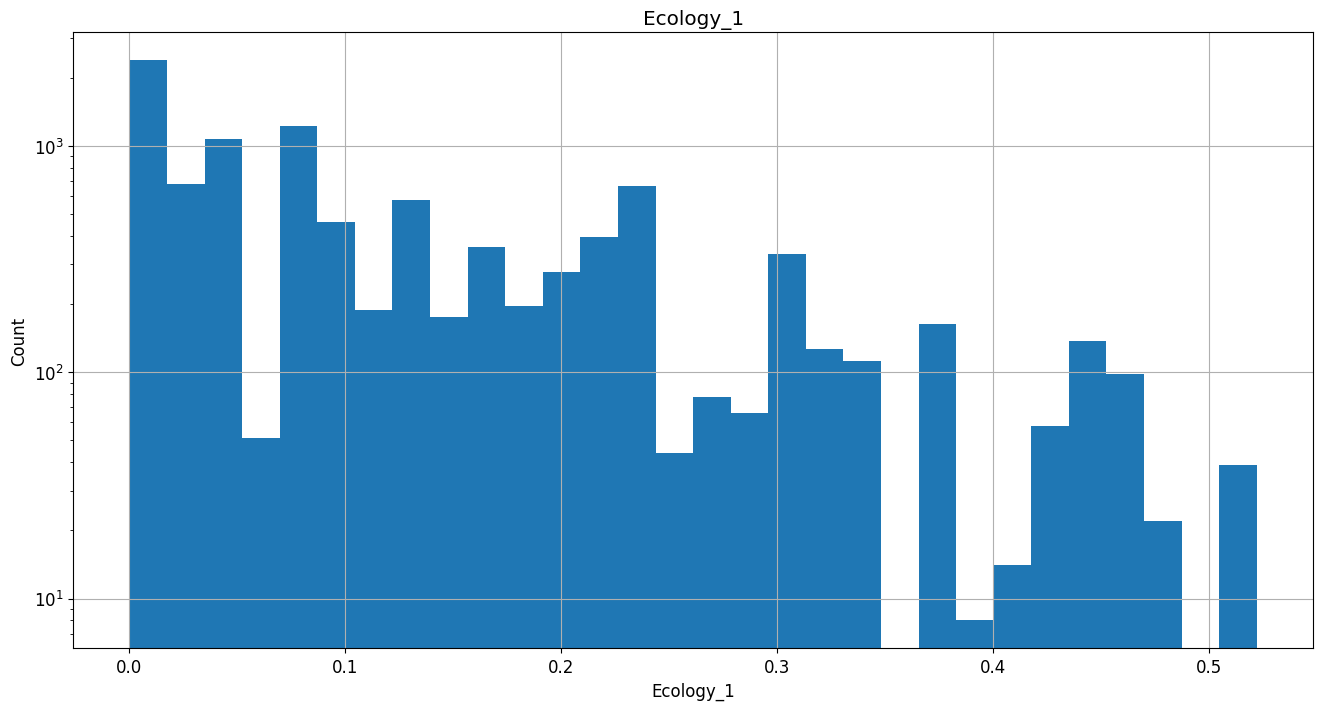

In [132]:
graph_log(train_df, 'Ecology_1', 30)

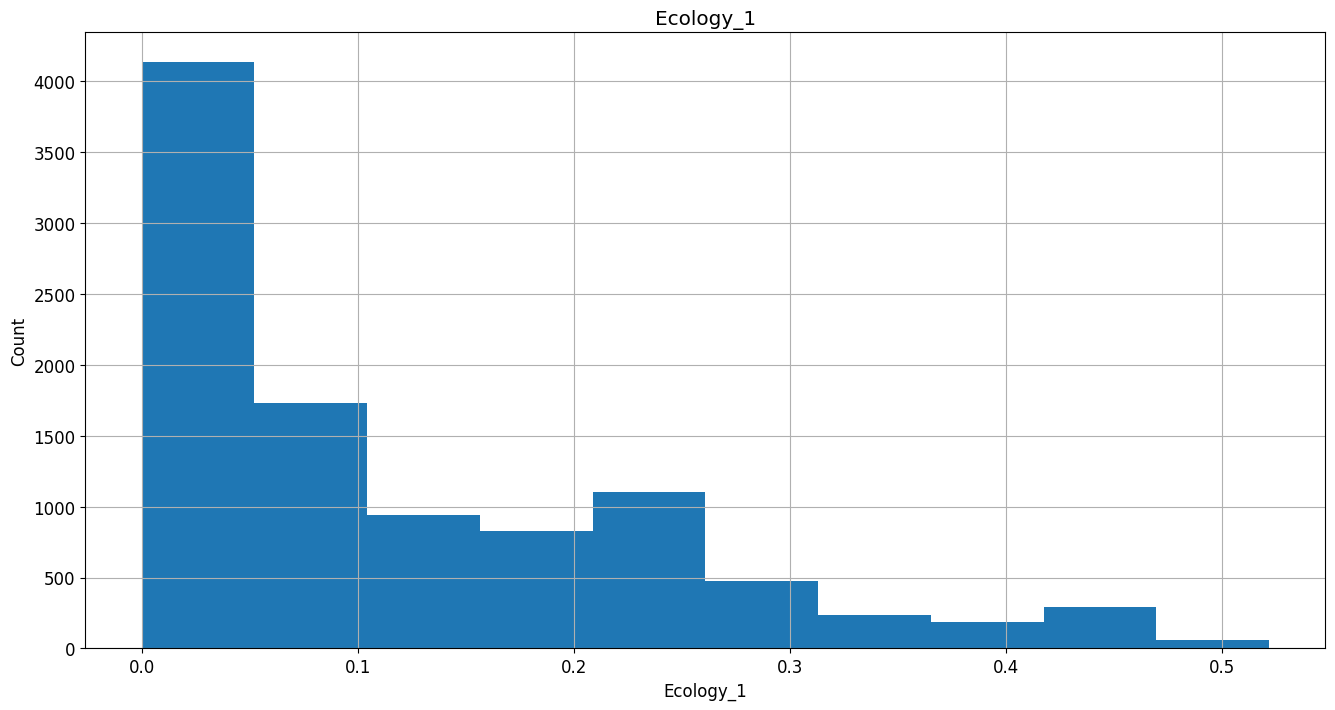

In [133]:
graph(train_df, 'Ecology_1', 10)

In [134]:
train_df['Ecology_1'].quantile(0.025)

0.0

In [135]:
quant_99 = train_df['Ecology_1'].quantile(0.99)
quant_99

0.4581744968891144

In [136]:
train_df[train_df['Ecology_1'] > quant_99]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier
6,14549,154,2,62.254112,37.160378,7.0,3,5,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.218750,0,0,0,3,0,0,8.0,0,0,0
133,15386,127,2,45.923672,26.177753,7.0,3,5,1967,0.486246,B,B,13,2514,19,NaN,0,6,B,176480.468750,0,0,0,3,0,1,7.0,0,0,0
149,10666,94,1,37.985752,20.142099,9.0,8,16,1974,0.521867,B,B,25,6149,0,NaN,0,0,B,137656.125000,0,0,0,8,0,0,6.0,0,0,0
189,3035,94,2,47.802227,32.542126,6.0,5,12,1975,0.521867,B,B,25,6149,0,NaN,0,0,B,162335.015625,0,0,0,5,0,0,7.0,0,0,0
191,14077,92,2,42.540092,27.662918,6.0,12,12,1971,0.460556,B,B,20,4386,14,NaN,1,5,B,208662.671875,0,0,0,12,0,0,6.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,4316,154,2,42.559296,28.620670,6.0,4,5,1963,0.460556,B,B,20,4386,14,NaN,1,5,B,224947.656250,0,0,0,4,0,0,7.0,0,0,0
9457,6481,94,3,60.431450,44.422165,6.0,4,5,1974,0.521867,B,B,25,6149,0,NaN,0,0,B,199206.140625,0,0,0,4,0,0,6.0,0,0,0
9523,1120,129,3,60.459576,32.259495,7.0,2,4,1954,0.460556,B,B,20,4386,14,NaN,1,5,B,296102.781250,0,0,0,2,0,0,7.0,0,0,0
9555,13949,94,1,41.897835,20.663256,9.0,10,16,1975,0.521867,B,B,25,6149,0,NaN,0,0,B,144207.328125,0,0,0,10,0,0,7.0,0,0,0


Распределение далеко не нормальное, потому выбросами считать не буду. Кроме того вообще не ясно что отражает численное значение показателя.

In [137]:
train_df['Ecology_1'].mode()

0    0.007122
Name: Ecology_1, dtype: float32

In [138]:
train_df[train_df['Ecology_1'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier
11,12427,31,3,68.808861,45.736904,7.0,1,8,1959,0.0,B,B,23,3684,2,NaN,0,4,B,165534.546875,0,0,0,1,0,0,8.0,0,0,0
35,6486,200,3,85.280388,58.447968,9.0,5,6,1960,0.0,B,B,33,7425,1,NaN,2,5,B,402871.906250,0,0,0,6,0,0,8.0,0,0,1
38,8224,177,3,77.873940,48.991135,12.0,9,25,2012,0.0,B,B,36,6714,2,2672.0,0,2,B,191550.125000,0,0,0,9,0,0,10.0,0,0,0
80,15600,108,2,49.888741,31.603651,6.0,9,12,1974,0.0,B,B,23,3684,2,NaN,0,4,B,261086.031250,0,0,0,9,0,0,6.0,0,0,0
83,2855,18,2,61.718552,33.040115,10.0,10,11,2000,0.0,B,B,30,5562,0,NaN,0,5,A,267609.812500,0,0,0,10,0,0,10.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9916,16712,109,2,58.139900,36.954605,10.0,14,18,1983,0.0,B,B,25,5027,4,46.0,1,1,B,363907.437500,0,0,0,14,0,0,8.0,0,0,0
9958,12878,46,1,39.143940,22.650690,8.0,12,14,1981,0.0,B,B,47,11319,0,1145.0,3,5,B,182459.515625,0,0,0,14,0,0,8.0,0,0,1
9968,6653,17,2,41.157436,27.489712,6.0,3,19,1967,0.0,B,B,18,3374,5,620.0,1,2,B,87265.398438,0,0,0,3,0,0,7.0,0,0,0
9996,6159,18,1,41.521545,20.539215,9.0,13,13,2000,0.0,B,B,30,5562,0,NaN,0,5,A,189050.296875,0,0,0,13,0,0,10.0,0,0,0


In [139]:
train_df['Ecology_1'].value_counts()

Ecology_1
0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.014334      1
0.012522      1
Name: count, Length: 129, dtype: int64

In [140]:
train_df['Ecology_1'].value_counts(bins=10)

Ecology_1
(-0.001522, 0.0522]    4137
(0.0522, 0.104]        1730
(0.209, 0.261]         1106
(0.104, 0.157]          941
(0.157, 0.209]          831
(0.261, 0.313]          477
(0.417, 0.47]           293
(0.313, 0.365]          239
(0.365, 0.417]          185
(0.47, 0.522]            61
Name: count, dtype: int64

In [141]:
train_df['Ecology_1'].sort_values().unique()

array([0.0000000e+00, 1.8000000e-09, 6.9989299e-05, 7.8152800e-05,
       1.6967600e-04, 6.9911900e-04, 9.9136296e-04, 9.9536299e-04,
       2.2116650e-03, 4.9493578e-03, 5.7674511e-03, 6.0761520e-03,
       7.1223169e-03, 7.6585151e-03, 7.7202818e-03, 1.1319810e-02,
       1.1654127e-02, 1.2338886e-02, 1.2521634e-02, 1.4057920e-02,
       1.4072961e-02, 1.4333947e-02, 1.4423114e-02, 1.4580716e-02,
       1.5016892e-02, 1.7647052e-02, 1.9508796e-02, 2.0741327e-02,
       2.5609156e-02, 3.3493709e-02, 3.4331497e-02, 3.4656081e-02,
       3.5145268e-02, 3.6122292e-02, 3.6270089e-02, 3.7177820e-02,
       3.7316453e-02, 3.8692988e-02, 4.0242765e-02, 4.1116353e-02,
       4.1124634e-02, 4.1365445e-02, 4.2031586e-02, 4.2307273e-02,
       4.9637258e-02, 4.9863387e-02, 5.0272014e-02, 5.0755568e-02,
       5.0900057e-02, 5.1815435e-02, 5.1942062e-02, 6.0753047e-02,
       6.9660343e-02, 6.9753364e-02, 7.2157584e-02, 7.5423680e-02,
       7.5778753e-02, 8.1943460e-02, 8.6885266e-02, 8.7619089e

#### *Смотрим Ecology_2*

In [142]:
train_df[['Ecology_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Ecology_2  10000 non-null  category
dtypes: category(1)
memory usage: 10.0 KB


In [143]:
train_df['Ecology_2'].value_counts()

Ecology_2
B    9903
A      97
Name: count, dtype: int64

In [144]:
train_df['Ecology_2_B'] = 1
train_df.loc[train_df['Ecology_2']=='A', 'Ecology_2_B'] = 0

In [145]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier,Ecology_2_B
9995,77,32,2,50.401787,30.476204,7.0,5,6,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500,0,0,0,6,0,1,7.0,0,0,1,1
9996,6159,18,1,41.521545,20.539215,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875,0,0,0,13,0,0,10.0,0,0,0,1
9997,5123,27,1,47.939007,38.351208,10.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500,0,1,0,12,0,1,10.0,0,0,0,1
9998,5400,75,2,43.602562,33.840149,8.0,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750,0,0,0,1,0,0,7.0,0,0,0,1
9999,6306,128,1,38.666645,21.157875,8.0,7,17,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.078125,0,0,0,7,0,0,8.0,0,0,0,1


#### *Смортим Ecology_3*

In [146]:
train_df[['Ecology_3']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Ecology_3  10000 non-null  category
dtypes: category(1)
memory usage: 10.0 KB


In [147]:
train_df['Ecology_3'].value_counts()

Ecology_3
B    9725
A     275
Name: count, dtype: int64

In [148]:
train_df['Ecology_3_B'] = 1
train_df.loc[train_df['Ecology_3']=='A', 'Ecology_3_B'] = 0

In [149]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier,Ecology_2_B,Ecology_3_B
9995,77,32,2,50.401787,30.476204,7.0,5,6,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500,0,0,0,6,0,1,7.0,0,0,1,1,1
9996,6159,18,1,41.521545,20.539215,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875,0,0,0,13,0,0,10.0,0,0,0,1,1
9997,5123,27,1,47.939007,38.351208,10.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500,0,1,0,12,0,1,10.0,0,0,0,1,1
9998,5400,75,2,43.602562,33.840149,8.0,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750,0,0,0,1,0,0,7.0,0,0,0,1,0
9999,6306,128,1,38.666645,21.157875,8.0,7,17,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.078125,0,0,0,7,0,0,8.0,0,0,0,1,1


#### *Смотрим признак Social_1*

In [150]:
train_df[['Social_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Social_1  10000 non-null  int8 
dtypes: int8(1)
memory usage: 9.9 KB


In [151]:
train_df[['Social_1']].describe()

,Social_1
count,10000.000000
mean,24.687000
std,17.532614
min,0.000000
25%,6.000000
50%,25.000000
75%,36.000000
max,74.000000


In [152]:
train_df['Social_1'].value_counts()

Social_1
2     688
1     654
25    557
5     528
30    465
23    434
6     377
22    367
53    355
34    311
33    252
46    245
31    243
43    238
9     213
36    209
21    207
24    205
37    205
52    201
0     201
35    200
47    177
74    176
39    159
27    151
28    144
4     141
11    138
42    129
26    127
16    123
19    118
66     99
17     96
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      62
15     51
20     50
14     46
10     24
13     22
12     18
7      15
3       9
Name: count, dtype: int64

In [153]:
train_df['Social_1'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 42, 43, 46, 47, 49, 50, 52, 53, 66, 74],
      dtype=int8)

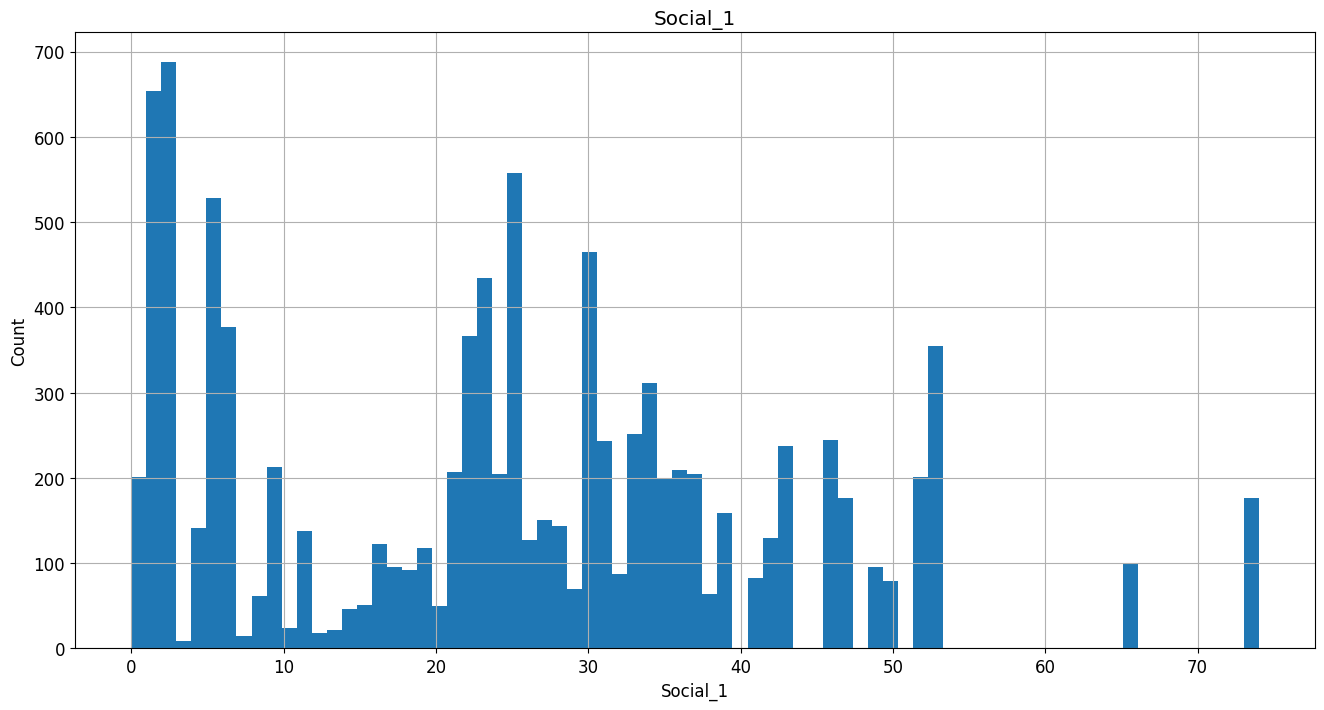

In [154]:
graph(train_df, 'Social_1', 75)

In [155]:
train_df['Social_1'].quantile(0.999)

74.0

In [156]:
train_df['Social_1'].quantile(0.01)

0.0

Выбросов нет

#### *Смотрим признак Social_2*

In [157]:
train_df[['Social_2']].describe()

,Social_2
count,10000.000000
mean,5352.157400
std,4006.799803
min,168.000000
25%,1564.000000
50%,5285.000000
75%,7227.000000
max,19083.000000


In [158]:
train_df['Social_2'].value_counts()

Social_2
264     587
1564    511
629     486
1437    346
6398    245
       ... 
1423      3
568       3
662       2
528       1
507       1
Name: count, Length: 142, dtype: int64

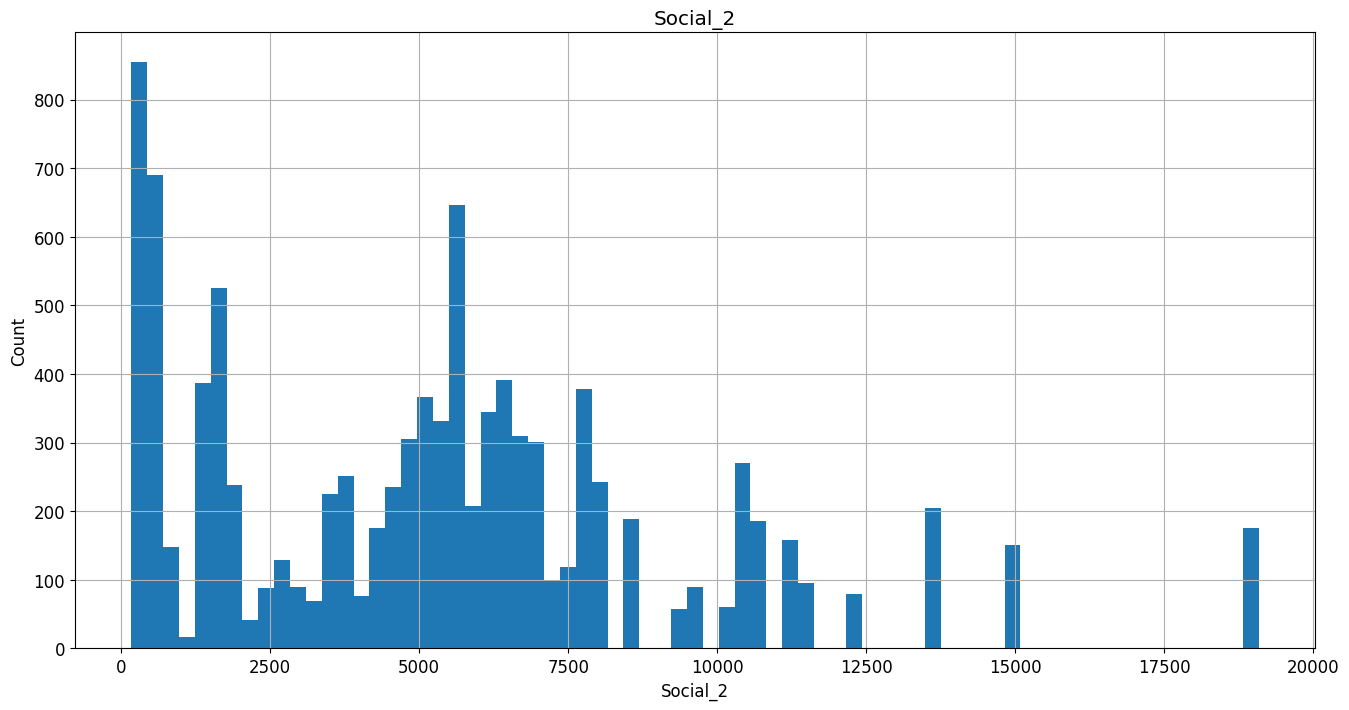

In [159]:
graph(train_df, 'Social_2', 71)

In [160]:
train_df['Social_2'].quantile(0.99)

19083.0

In [161]:
train_df['Social_2'].quantile(0.01)

168.0

Выбросов нет

#### *Смотрим признак Social_3*

In [162]:
train_df[['Social_3']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Social_3  10000 non-null  int16
dtypes: int16(1)
memory usage: 19.7 KB


In [163]:
train_df[['Social_3']].describe()

,Social_3
count,10000.000000
mean,8.039200
std,23.831875
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,141.000000


In [164]:
train_df['Social_3'].value_counts()

Social_3
0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
59       25
93       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: count, dtype: int64

In [165]:
train_df['Social_3'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,
        16,  19,  20,  23,  24,  27,  37,  39,  45,  48,  56,  59,  73,
        84,  87,  93, 141], dtype=int16)

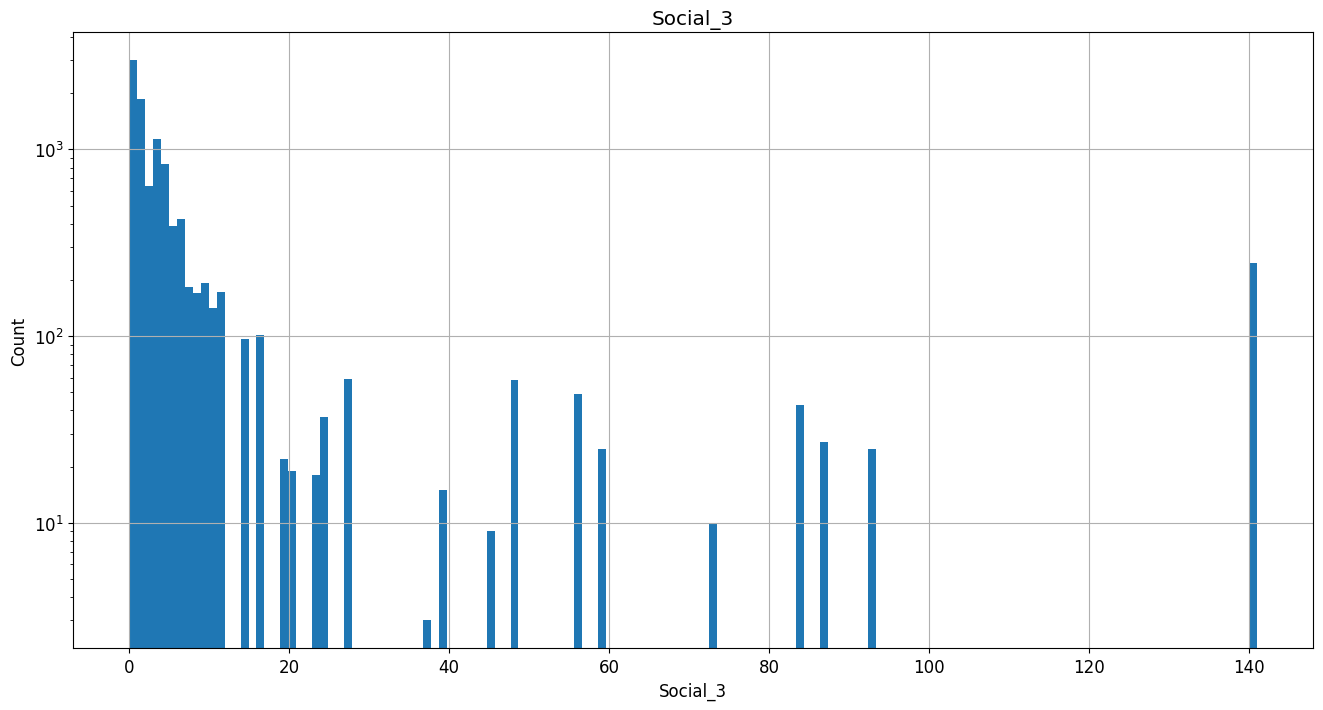

In [166]:
graph_log(train_df, 'Social_3', 142)

In [167]:
train_df['Social_3'].quantile(0.99)

141.0

In [168]:
train_df['Social_3'].quantile(0.01)

0.0

Выбросов нет

#### *Смотрим признак Healthcare_1*

In [169]:
train_df[['Healthcare_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Healthcare_1  5202 non-null   float32
dtypes: float32(1)
memory usage: 39.2 KB


In [170]:
train_df[['Healthcare_1']].describe()

,Healthcare_1
count,5202.000000
mean,1142.904419
std,1021.517273
min,0.000000
25%,350.000000
50%,900.000000
75%,1548.000000
max,4849.000000


In [171]:
train_df['Healthcare_1'].value_counts()

Healthcare_1
540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: count, Length: 79, dtype: int64

In [172]:
train_df['Healthcare_1'].sort_values().unique()

array([   0.,   30.,   32.,   35.,   46.,   75.,   80.,  100.,  125.,
        145.,  165.,  176.,  192.,  200.,  229.,  240.,  262.,  320.,
        325.,  350.,  370.,  520.,  540.,  562.,  620.,  628.,  645.,
        705.,  730.,  750.,  770.,  800.,  810.,  830.,  900.,  920.,
        990., 1015., 1020., 1036., 1046., 1084., 1130., 1145., 1183.,
       1308., 1322., 1340., 1406., 1430., 1450., 1547., 1548., 1575.,
       1786., 1815., 1894., 1937., 1940., 1970., 1994., 2078., 2300.,
       2301., 2500., 2620., 2643., 2672., 2715., 2729., 2857., 2890.,
       3300., 3855., 4087., 4129., 4508., 4702., 4849.,   nan],
      dtype=float32)

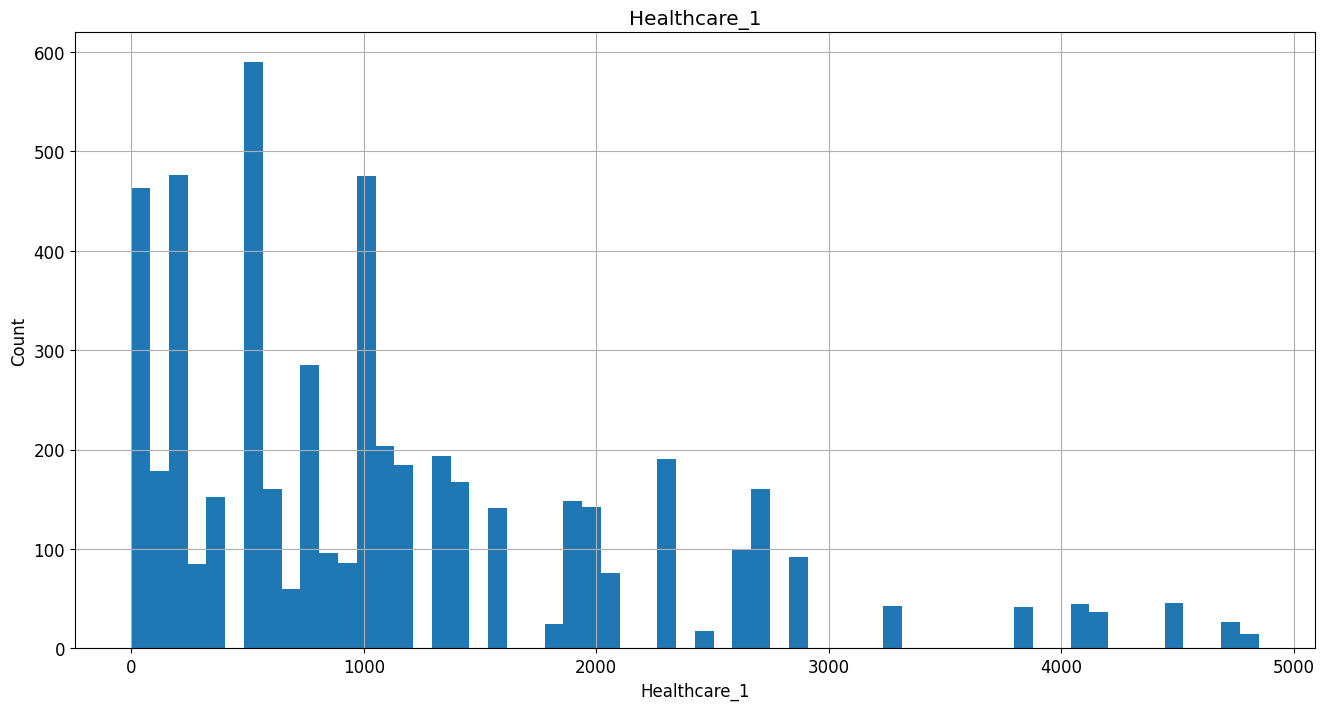

In [173]:
graph(train_df, 'Healthcare_1', 60)

In [174]:
train_df['Healthcare_1'].quantile(0.99)

4508.0

In [175]:
train_df['Healthcare_1'].quantile(0.01)

30.0

In [176]:
train_df[pd.isnull(train_df['Healthcare_1'])]['Healthcare_1']

0      NaN
6      NaN
7      NaN
8      NaN
9      NaN
        ..
9992   NaN
9993   NaN
9994   NaN
9996   NaN
9997   NaN
Name: Healthcare_1, Length: 4798, dtype: float32

Почти у половины наблюдений нет значения. И на фоне того, что неизвестно что конкретно означает численное выражение признака, имеет смысл вообще выбросить этот признак из рассмотрения.

In [177]:
train_df = train_df.drop('Healthcare_1', axis=1)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier,Ecology_2_B,Ecology_3_B
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,0,11,B,184966.937500,0,0,0,7,0,0,6.0,0,0,0,1,1
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,1,16,B,300009.437500,0,0,0,7,0,0,8.0,0,0,0,1,1
2,4765,53,2,44.947952,29.197611,7.0,8,12,1968,0.049637,B,B,34,7759,0,1,3,B,220925.906250,0,0,0,8,0,1,7.0,0,0,0,1,1
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,0,5,B,175616.234375,0,0,0,8,0,0,9.0,0,0,0,1,1
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531250,0,0,0,11,0,0,7.0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401787,30.476204,7.0,5,6,1968,0.135650,B,B,46,7960,6,3,11,B,196684.312500,0,0,0,6,0,1,7.0,0,0,1,1,1
9996,6159,18,1,41.521545,20.539215,9.0,13,13,2000,0.000000,B,B,30,5562,0,0,5,A,189050.296875,0,0,0,13,0,0,10.0,0,0,0,1,1
9997,5123,27,1,47.939007,38.351208,10.0,12,16,2015,0.072158,B,B,2,629,1,0,0,A,159143.812500,0,1,0,12,0,1,10.0,0,0,0,1,1
9998,5400,75,2,43.602562,33.840149,8.0,1,5,1961,0.307467,B,A,30,5048,9,2,5,B,181595.343750,0,0,0,1,0,0,7.0,0,0,0,1,0


#### *Смотрим признак 'Helthcare_2'*

In [178]:
train_df[['Helthcare_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Helthcare_2  10000 non-null  int8 
dtypes: int8(1)
memory usage: 9.9 KB


In [179]:
train_df[['Helthcare_2']].describe()

,Helthcare_2
count,10000.000000
mean,1.319500
std,1.493601
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,6.000000


In [180]:
train_df['Helthcare_2'].value_counts()

Helthcare_2
0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: count, dtype: int64

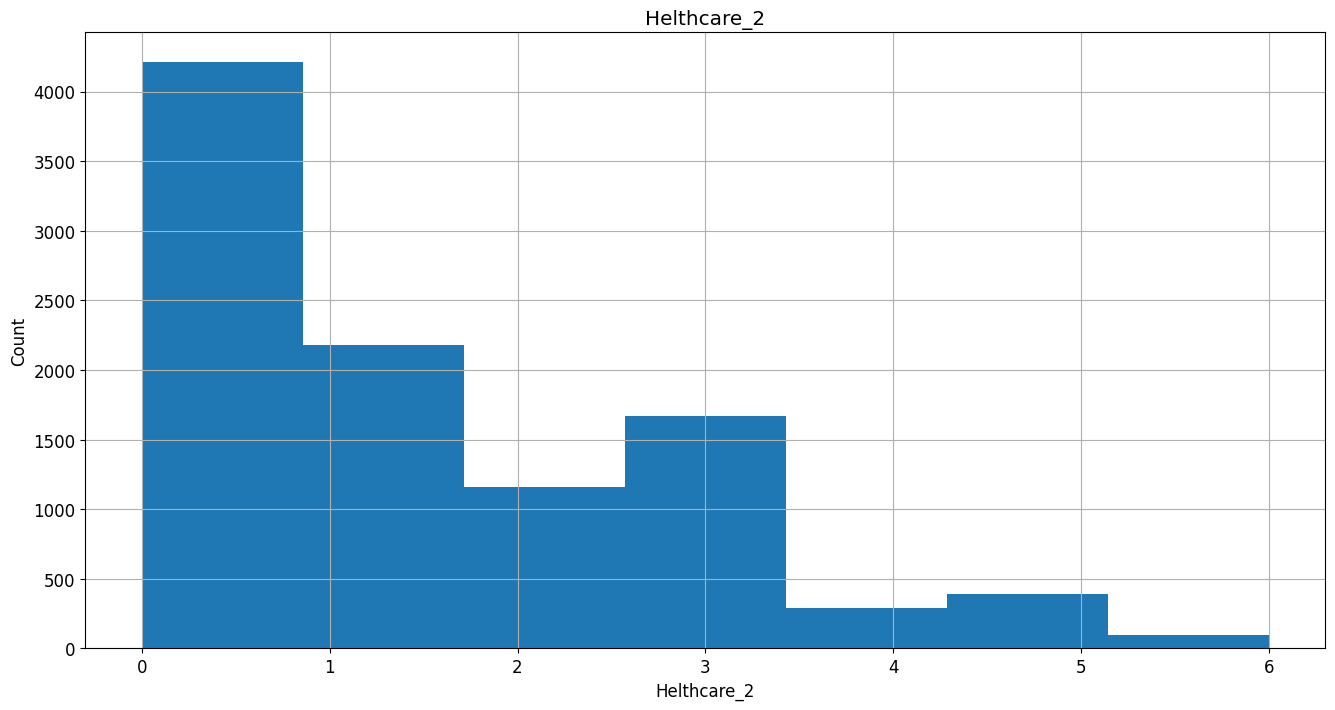

In [181]:
graph(train_df, 'Helthcare_2', 7)

In [182]:
train_df['Helthcare_2'].quantile(0.99)

5.0

In [183]:
train_df['Helthcare_2'].quantile(0.01)

0.0

Признак 'Helthcare_2' оставляем без изменений.  Значение равное 6 за выброс считать не будем, так как распределение далеко не нормальное. Пропусков нет.

#### *Смотрим признак 'Shops_1'*

In [184]:
train_df[['Shops_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Shops_1  10000 non-null  int8 
dtypes: int8(1)
memory usage: 9.9 KB


In [185]:
train_df[['Shops_1']].describe()

,Shops_1
count,10000.000000
mean,4.231300
std,4.806341
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,23.000000


In [186]:
train_df['Shops_1'].value_counts()

Shops_1
0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: count, dtype: int64

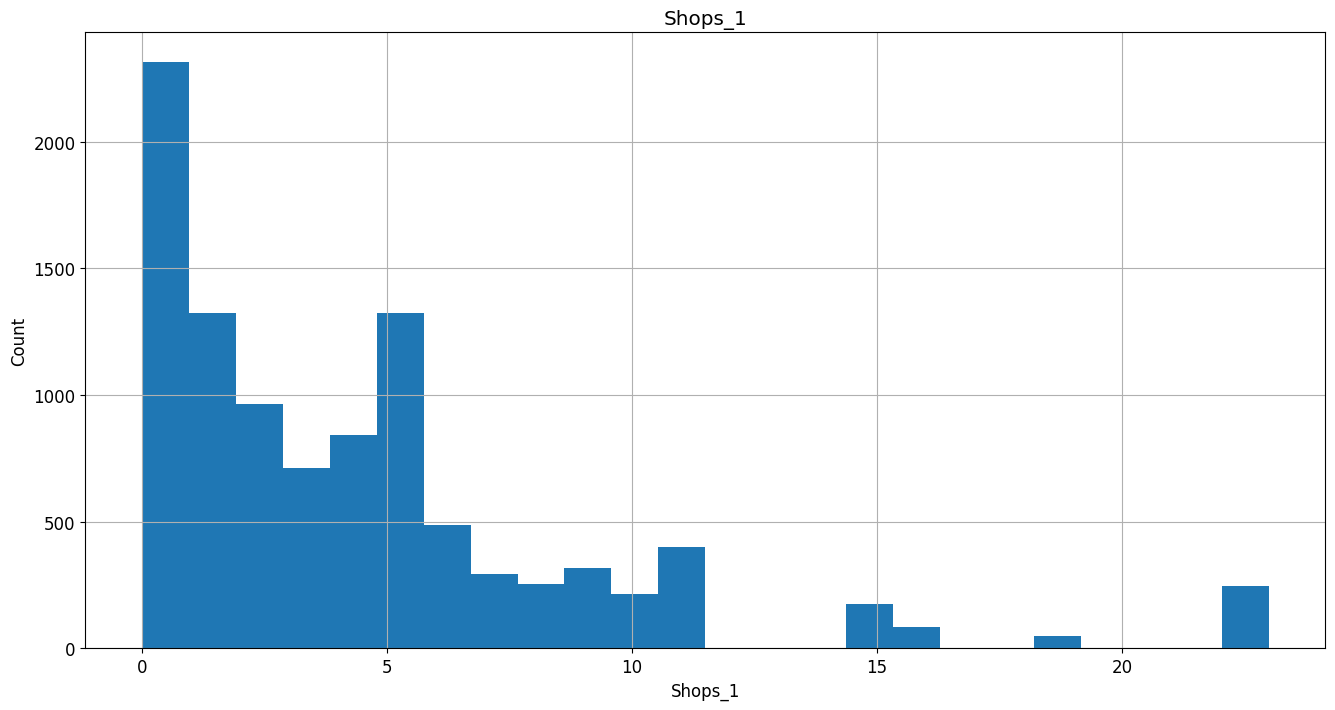

In [187]:
graph(train_df, 'Shops_1', 24)

In [188]:
train_df['Shops_1'].quantile(0.99)

23.0

In [189]:
train_df['Shops_1'].quantile(0.01)

0.0

Выбросов нет

#### *Смотрим признак Shops_2*

In [190]:
train_df[['Shops_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Shops_2  10000 non-null  category
dtypes: category(1)
memory usage: 10.0 KB


In [191]:
train_df['Shops_2'].value_counts()

Shops_2
B    9175
A     825
Name: count, dtype: int64

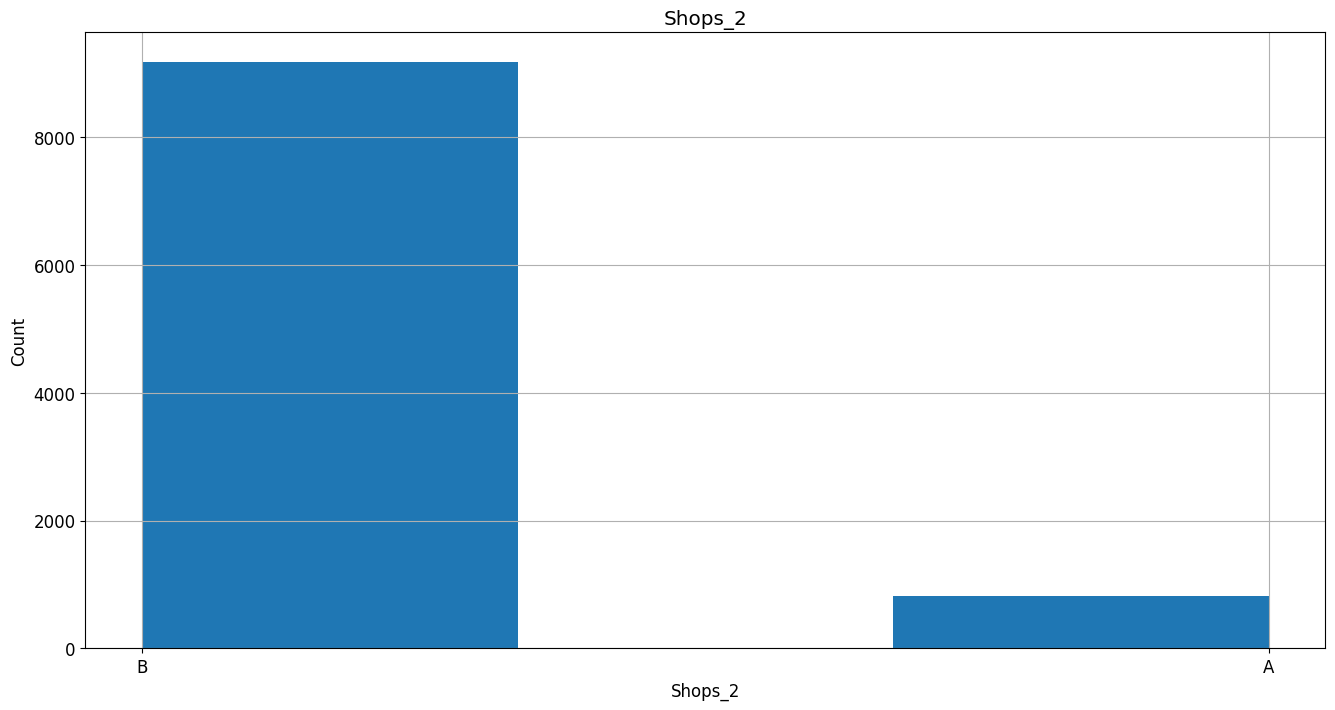

In [192]:
graph(train_df, 'Shops_2', 3)

In [193]:
train_df['Shops_2_B'] = 1
train_df.loc[train_df['Shops_2']=='A', 'Shops_2_B'] = 0

In [194]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier,Ecology_2_B,Ecology_3_B,Shops_2_B
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,0,11,B,184966.937500,0,0,0,7,0,0,6.0,0,0,0,1,1,1
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,1,16,B,300009.437500,0,0,0,7,0,0,8.0,0,0,0,1,1,1
2,4765,53,2,44.947952,29.197611,7.0,8,12,1968,0.049637,B,B,34,7759,0,1,3,B,220925.906250,0,0,0,8,0,1,7.0,0,0,0,1,1,1
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,0,5,B,175616.234375,0,0,0,8,0,0,9.0,0,0,0,1,1,1
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531250,0,0,0,11,0,0,7.0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401787,30.476204,7.0,5,6,1968,0.135650,B,B,46,7960,6,3,11,B,196684.312500,0,0,0,6,0,1,7.0,0,0,1,1,1,1
9996,6159,18,1,41.521545,20.539215,9.0,13,13,2000,0.000000,B,B,30,5562,0,0,5,A,189050.296875,0,0,0,13,0,0,10.0,0,0,0,1,1,0
9997,5123,27,1,47.939007,38.351208,10.0,12,16,2015,0.072158,B,B,2,629,1,0,0,A,159143.812500,0,1,0,12,0,1,10.0,0,0,0,1,1,0
9998,5400,75,2,43.602562,33.840149,8.0,1,5,1961,0.307467,B,A,30,5048,9,2,5,B,181595.343750,0,0,0,1,0,0,7.0,0,0,0,1,0,1


### Генерация новых признаков

#### *Первый или последний этаж*

In [195]:
train_df['ExtremeFloor'] = 0
train_df.loc[(train_df['Floor'] == 1) | (train_df['Floor'] == train_df['HouseFloor']), 'ExtremeFloor'] = 1

#### *Количество квартир из округа*

In [196]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'count':'DistrictSize'}) # для Colaboratory
# district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'DistrictId':'DistrictSize', 'index':'DistrictId'}) # для локального Python 3.8
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [197]:
district_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   DistrictId    205 non-null    category
 1   DistrictSize  205 non-null    int64   
dtypes: category(1), int64(1)
memory usage: 11.8 KB


In [198]:
train_df[['DistrictId']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DistrictId  10000 non-null  category
dtypes: category(1)
memory usage: 29.4 KB


In [199]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier,Ecology_2_B,Ecology_3_B,Shops_2_B,ExtremeFloor,DistrictSize
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,0,11,B,184966.937500,0,0,0,7,0,0,6.0,0,0,0,1,1,1,0,22
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,1,16,B,300009.437500,0,0,0,7,0,0,8.0,0,0,0,1,1,1,0,87
2,4765,53,2,44.947952,29.197611,7.0,8,12,1968,0.049637,B,B,34,7759,0,1,3,B,220925.906250,0,0,0,8,0,1,7.0,0,0,0,1,1,1,0,174
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,0,5,B,175616.234375,0,0,0,8,0,0,9.0,0,0,0,1,1,1,0,179
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531250,0,0,0,11,0,0,7.0,0,0,0,1,1,1,0,97


In [200]:
train_df['DistrictSize'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  31,  32,  33,  34,  35,  36,  37,  40,  41,  42,
        43,  44,  46,  48,  49,  51,  55,  56,  57,  58,  59,  61,  62,
        64,  65,  66,  67,  71,  72,  73,  76,  77,  78,  79,  80,  82,
        87,  89,  90,  92,  97, 104, 107, 111, 114, 116, 118, 119, 129,
       142, 143, 165, 174, 179, 228, 247, 294, 511, 565, 652, 851])

In [201]:
train_df['DistrictSize'].describe()

count    10000.000000
mean       242.306600
std        268.992652
min          1.000000
25%         55.000000
50%        104.000000
75%        511.000000
max        851.000000
Name: DistrictSize, dtype: float64

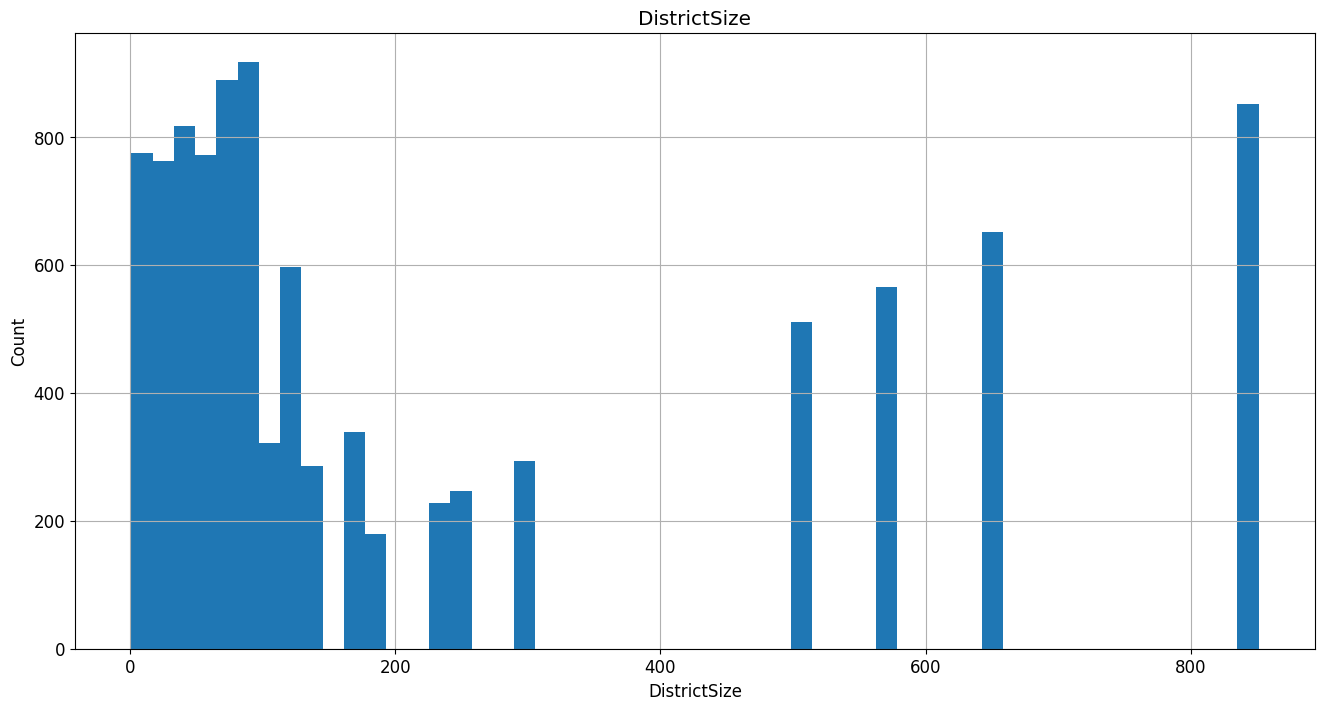

In [202]:
graph(train_df, 'DistrictSize', 53)

#### *Цена квадратного метра и средняя цена кадратного метра вокруге*

In [203]:
train_df['Price_m2']=train_df['Price']/train_df['Square']

In [204]:
train_df['Price_m2'].describe()

count    10000.000000
mean      3886.323486
std       1259.484131
min        638.982117
25%       2907.820679
50%       3904.444946
75%       4689.951172
max      17348.253906
Name: Price_m2, dtype: float64

In [205]:
quant_99 = train_df['Price_m2'].quantile(.99)
quant_99

7203.427744140625

In [206]:
quant_01 = train_df['Price_m2'].quantile(.01)
quant_01

1381.993798828125

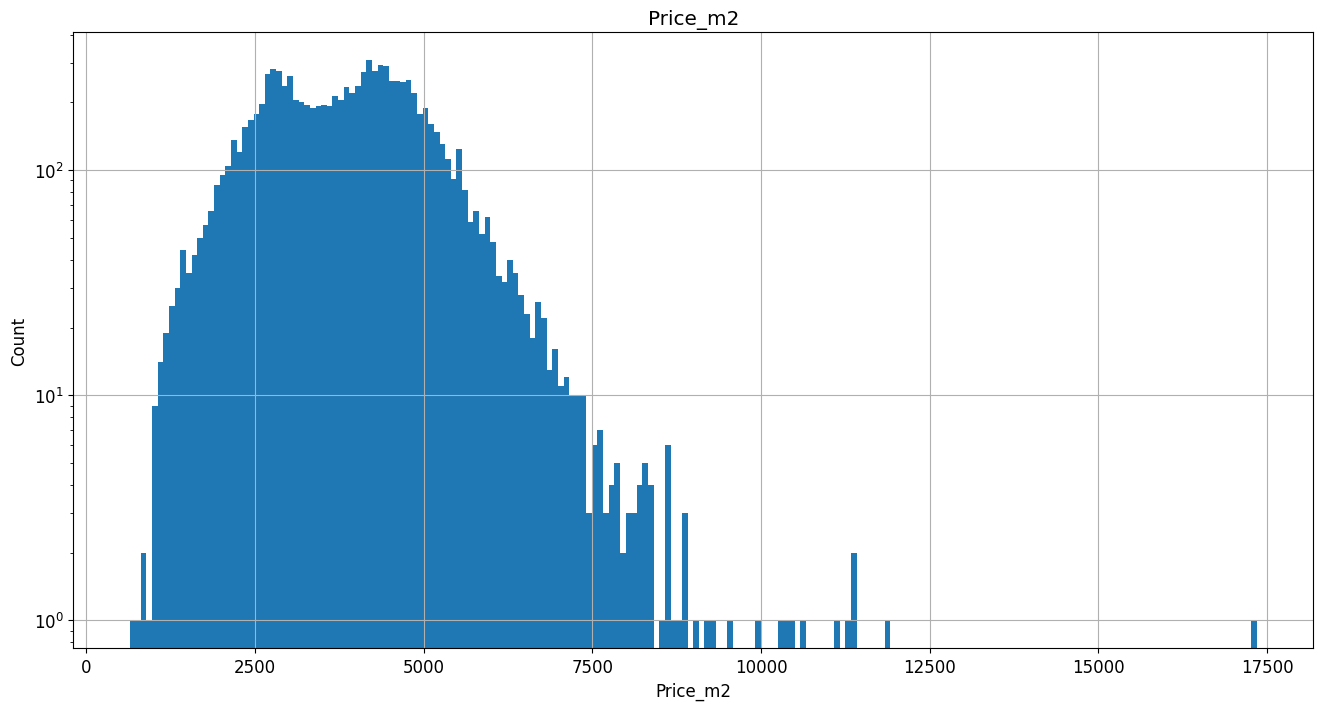

In [207]:
graph_log(train_df, 'Price_m2', 200)

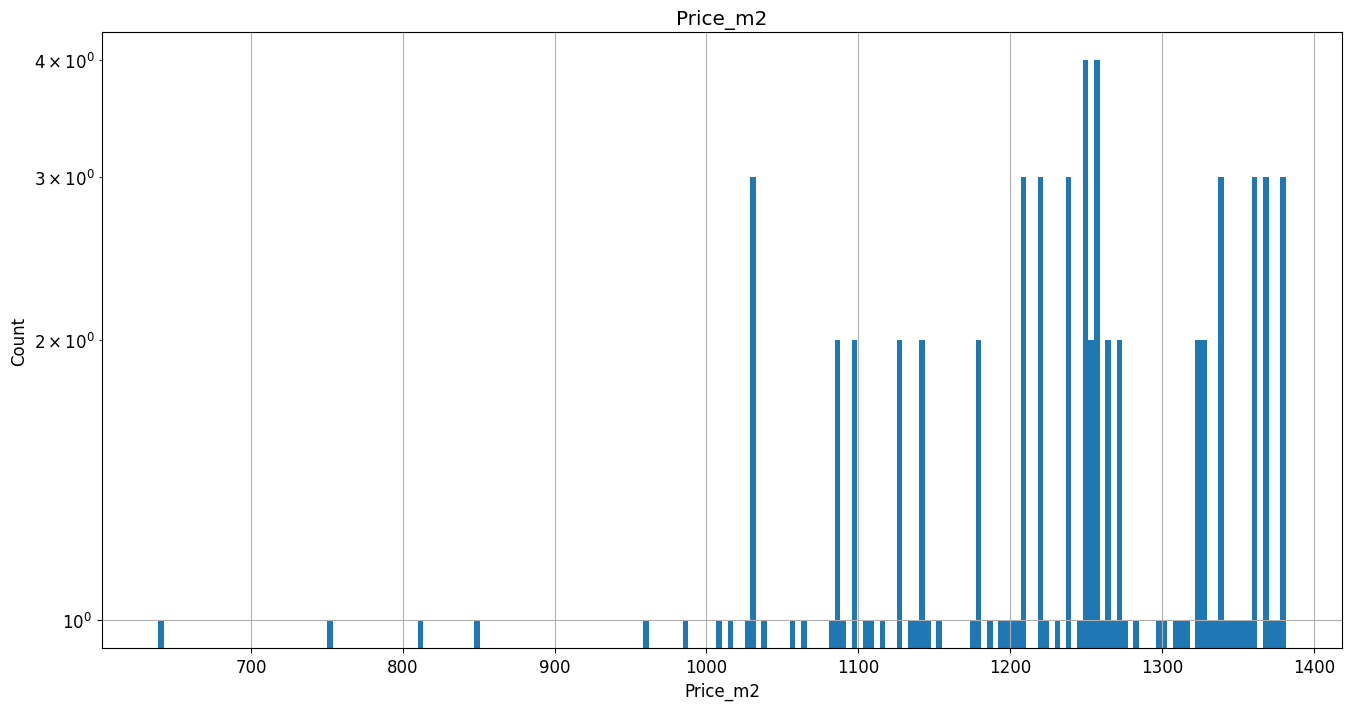

In [208]:
graph_log(train_df.loc[train_df['Price_m2']<quant_01], 'Price_m2', 200)

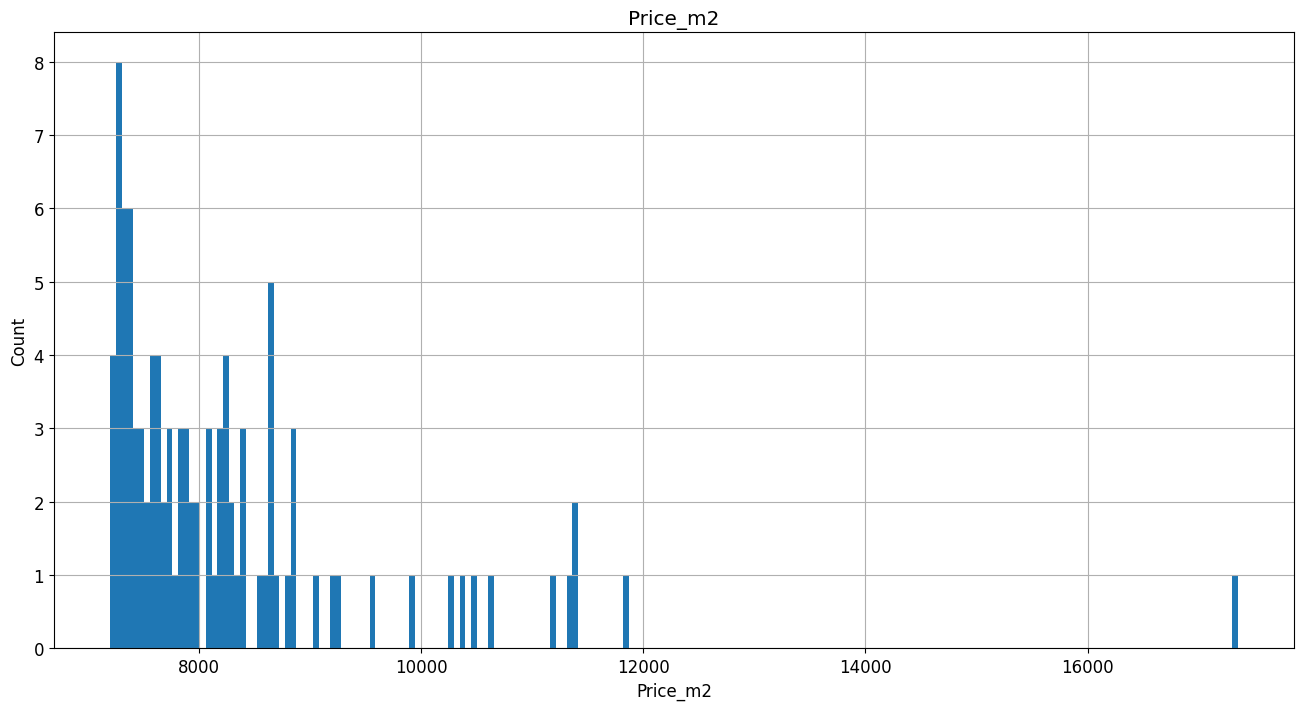

In [209]:
graph(train_df.loc[train_df['Price_m2']>quant_99], 'Price_m2', 200)

In [210]:
train_df.loc[(train_df['Price_m2']<1200)].count()

Id                            39
DistrictId                    39
Rooms                         39
Square                        39
LifeSquare                    39
KitchenSquare                 39
Floor                         39
HouseFloor                    39
HouseYear                     39
Ecology_1                     39
Ecology_2                     39
Ecology_3                     39
Social_1                      39
Social_2                      39
Social_3                      39
Helthcare_2                   39
Shops_1                       39
Shops_2                       39
Price                         39
Square_outlier                39
LifeSquare_outlier            39
Rooms_outlier                 39
temporarily                   39
HouseYear_outlier             39
KitchenSquare_outlier         39
KitchenSquare_mean_in_year    39
Studio                        39
Floor_outlier                 39
HouseFloor_outlier            39
Ecology_2_B                   39
Ecology_3_

In [211]:
train_df.loc[(train_df['Price_m2']>8000)].count()

Id                            46
DistrictId                    46
Rooms                         46
Square                        46
LifeSquare                    46
KitchenSquare                 46
Floor                         46
HouseFloor                    46
HouseYear                     46
Ecology_1                     46
Ecology_2                     46
Ecology_3                     46
Social_1                      46
Social_2                      46
Social_3                      46
Helthcare_2                   46
Shops_1                       46
Shops_2                       46
Price                         46
Square_outlier                46
LifeSquare_outlier            46
Rooms_outlier                 46
temporarily                   46
HouseYear_outlier             46
KitchenSquare_outlier         46
KitchenSquare_mean_in_year    46
Studio                        46
Floor_outlier                 46
HouseFloor_outlier            46
Ecology_2_B                   46
Ecology_3_

Считаю, что данные строки стоит удалить, так как цена за квадратный метр у этих квартир сильно выбивается из общей массы, то есть является нехарактерной и будет отрицательно влиять на точность модели.

In [212]:
train_df['Delete'] = 0
train_df.loc[(train_df['Price_m2']<1200) | (train_df['Price_m2']>8000), 'Delete'] = 1

In [213]:
train_df.groupby(['DistrictId'], as_index=False).agg({'Price_m2':'median'})

,DistrictId,Price_m2
0,0,3935.906738
1,1,3248.401611
2,10,4458.893555
3,100,4933.390137
4,101,4188.414551
...,...,...
200,95,5496.385742
201,96,4025.341797
202,97,4942.568359
203,98,4444.979980


In [214]:
med_price_m2_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'Price_m2':'median'}).rename(columns={'Price_m2':'MedPriceM2ByDistrict'})

In [215]:
train_df = train_df.merge(med_price_m2_by_district, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,LifeSquare_outlier,Rooms_outlier,temporarily,HouseYear_outlier,KitchenSquare_outlier,KitchenSquare_mean_in_year,Studio,Floor_outlier,HouseFloor_outlier,Ecology_2_B,Ecology_3_B,Shops_2_B,ExtremeFloor,DistrictSize,Price_m2,Delete,MedPriceM2ByDistrict
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,0,11,B,184966.937500,0,0,0,7,0,0,6.0,0,0,0,1,1,1,0,22,3854.958740,0,4358.274902
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,1,16,B,300009.437500,0,0,0,7,0,0,8.0,0,0,0,1,1,1,0,87,4567.491211,0,4437.304199
2,4765,53,2,44.947952,29.197611,7.0,8,12,1968,0.049637,B,B,34,7759,0,1,3,B,220925.906250,0,0,0,8,0,1,7.0,0,0,0,1,1,1,0,174,4915.149414,0,4830.233887
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,0,5,B,175616.234375,0,0,0,8,0,0,9.0,0,0,0,1,1,1,0,179,3291.591797,0,2949.975342
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531250,0,0,0,11,0,0,7.0,0,0,0,1,1,1,0,97,3788.892578,0,3992.031250


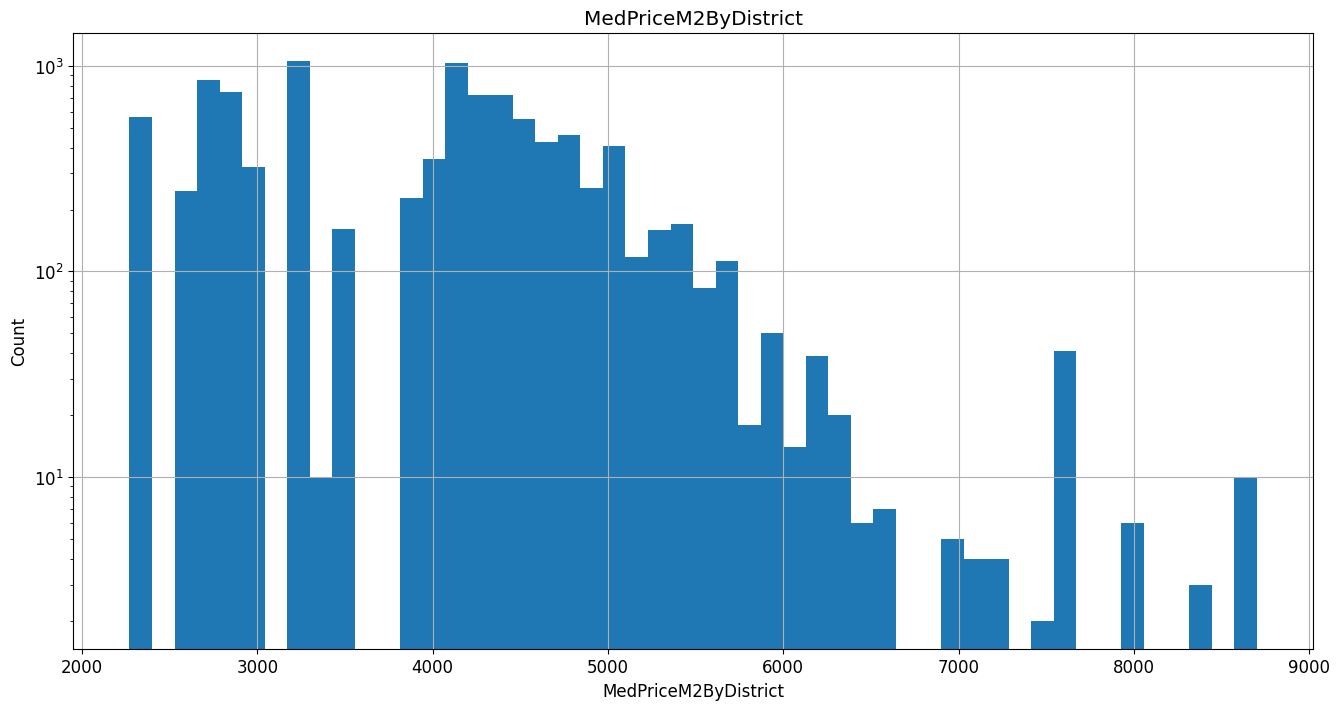

In [216]:
graph_log(train_df, 'MedPriceM2ByDistrict', 50)

In [217]:
# Сохраняем результат
train_df.to_csv('./01 train_save_b.csv', index=False, encoding='utf-8', sep=',')

# Загружаем данные

In [218]:
# заново загружаем
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [219]:
submit = pd.DataFrame({'Id': range(0, 5000), 'Price': -1})
submit['Id'] = test_df['Id']

In [220]:
train_df.shape, test_df.shape, submit.shape

((10000, 20), (5000, 19), (5000, 2))

### Создаём класс для трансформации данных

In [221]:
DICT_COL = {'Id':str, 'DistrictId':str, 'Rooms':int, 'HouseFloor':int}

In [222]:
SQUARE_MAX = 300 # Максимальная площадь квартиры
SQUARE_MIN = 10 # Минимальная площадь квартиры
KOEF_LIFE = 0.8 # Коэффициент на вычитание площади коридоров, кладовок и санузлов
S_ROOM_MEAN = 10 # Минимальная средняя площадь комнаты в квартире 10 м2

Так как не будем использовать сгенерированные признаки изменения признака, то и не будем их генерировать

In [223]:
# Трансформация данных
class Data_Preprocess:

    def transform(self, X):
        """Трансформация данных"""
        X = convert_type(X, DICT_COL) # конвертируем поля

        # поле Square
        X.loc[(X['Square'] > SQUARE_MAX), 'Square'] = X['Square']/10 # делим выбросы на 10, т.к. похоже, что шиблись в запятой
        X.loc[(X['Square'] > SQUARE_MAX), 'LifeSquare'] = X['LifeSquare']/10
        X.loc[(X['Square'] < SQUARE_MIN), 'Square'] = X['Square']*10 # умножим выбросы на 10, т.к. похоже, что шиблись в запятой
        X.loc[(X['Square'] < SQUARE_MIN), 'Square'] = X['Square']*10 # на всякий случай
        quant_025 = X['Square'].quantile(.025) # Факт - такие квартиры бывают.
        # Скорректируем кол-во комнат в квартирах < 32 м
        X.loc[(X['Square'] < quant_025) & (X['Rooms'] > 1), 'Rooms'] = 1

        # поле LifeSquare
        X.loc[(X['LifeSquare'] > SQUARE_MAX*KOEF_LIFE), 'LifeSquare'] = X['LifeSquare']/10 #делим выбросы на 10, т.к. похоже, что шиблись в запятой
        X.loc[(X['LifeSquare'] > SQUARE_MAX*KOEF_LIFE), 'LifeSquare'] = X['LifeSquare']/10
        X.loc[(X['LifeSquare'] < SQUARE_MIN*KOEF_LIFE), 'LifeSquare'] = X['LifeSquare']*10 # умножим выбросы на 10, т.к. похоже, что шиблись в запятой
        X.loc[(X['LifeSquare'] < SQUARE_MIN*KOEF_LIFE), 'LifeSquare'] = X['LifeSquare']*10
        # Меняем их местами
        X['temporarily'] = X['Square']
        X.loc[(X['LifeSquare'] > X['Square']), 'Square'] = X['LifeSquare']
        X.loc[(X['LifeSquare'] > X['temporarily']), 'LifeSquare'] = X['temporarily']
        # Заполним пустые значения
        X.loc[pd.isnull(X['LifeSquare']), 'LifeSquare'] = X['Square']*KOEF_LIFE

        # поле Rooms
        list_diapason = [SQUARE_MAX, 180, 150, 110, 70, 45, SQUARE_MIN]
        for i in range(len(list_diapason)-1):
            condition = round(X.loc[(X['Square'] <= list_diapason[i]) & (X['Square'] > list_diapason[i+1]) & (X['Rooms'] != 0) & (X['Rooms'] <= 5), 'Rooms'].mean())
            X.loc[(X['Square'] <= list_diapason[i]) & (X['Square'] > list_diapason[i+1]) & ((X['Rooms'] > 5) | (X['Rooms'] <= 0) | (X['Square'] < S_ROOM_MEAN * X['Rooms'] / KOEF_LIFE)), 'Rooms'] = condition

        # поле HouseYear
        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2005
        list_unique_HouseYear = X['HouseYear'].sort_values().unique()

        # поле KitchenSquare
        X.loc[(X['KitchenSquare'] > 1900) & (X['KitchenSquare'] < X['HouseYear']), 'HouseYear'] = X['KitchenSquare']
        group = X.loc[(X['KitchenSquare']>5) & (X['KitchenSquare']<40)].groupby('HouseYear')
        group = group['KitchenSquare'].median()
        list_unique_HouseYear = list(list_unique_HouseYear)
        group_min_max = X.loc[(X['KitchenSquare']<=5) | (X['KitchenSquare']>=40)].groupby('HouseYear')
        group_min_max = group_min_max['KitchenSquare'].median()
        for i in list_unique_HouseYear:
            if i not in list(group.index):
                group[i] = list(group_min_max[[i]])[0]
        X['KitchenSquare_mean_in_year']=list(group[X['HouseYear']])
        X.loc[(X['KitchenSquare']>1900), 'KitchenSquare'] = X['KitchenSquare_mean_in_year']
        # площадь кухни больше площади квартиры
        X.loc[(X['KitchenSquare']>X['Square']), 'KitchenSquare'] = X['KitchenSquare']/10 # поделим выбросы на 10, т.к. похоже, что шиблись в запятой
        X.loc[(X['KitchenSquare']>X['Square']), 'KitchenSquare'] = X['KitchenSquare']/10 # на всякий случай
        # Теперь надо разобраться с кухнями <=5 м**2.
        X.loc[(X['KitchenSquare']<=5), 'KitchenSquare'] = X['KitchenSquare_mean_in_year']
        X.loc[X['KitchenSquare']>45, 'KitchenSquare'] = X['KitchenSquare_mean_in_year']

        # поле HouseFloor
        X.loc[X['HouseFloor']==99, 'HouseFloor'] = 9
        X.loc[X['HouseFloor']==117, 'HouseFloor'] = 17
        # уберём этажи квартир выше 48 - считаем, что, скорее всего, там первая цифра случайно нажата
        X.loc[(X['Floor'] > 48), 'Floor'] = X['Floor'] % 10
        # этаж квартиры больше этажности дома
        # Предположу, что перепутаны данные по этажу и этажности дома. Поменяем их местами.
        X['temporarily'] = X['Floor']
        X.loc[(X['HouseFloor'] < X['Floor']) & (X['HouseFloor'] != 0), 'Floor'] = X['HouseFloor']
        X.loc[(X['HouseFloor'] < X['temporarily']) & (X['HouseFloor'] != 0), 'HouseFloor'] = X['temporarily']
        # Теперь домам с нулевой этажностью назначим самую часто встречающуюся этажность
        X.loc[(X['Floor'] > X['HouseFloor']), 'HouseFloor'] = X['HouseFloor'].mode()[0]
        # У квартир, этаж которых выше этажности дома, приравняем этажность к этажу квартиры.
        X.loc[(X['Floor'] > X['HouseFloor']), 'HouseFloor'] = X['Floor']

        # поле Healthcare_1
        X = X.drop('Healthcare_1', axis=1)
        return X

preprocessor = Data_Preprocess()

In [224]:
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [225]:
train_df.shape, test_df.shape

((10000, 21), (5000, 20))

#### Разбиение train

In [226]:
target_name = 'Price'
X_train = train_df.drop(columns=target_name)
y_train = train_df[target_name]

### Класс для генерации новых фич

In [227]:
class FeatureGenetator():
    """Генерация новых фич"""

    def __init__(self):
        self.binary_to_numbers = {'A': 0, 'B': 1} # МАСКА ПЕРЕВОДА
        self.med_price_m2_by_district = None
        self.med_price_m2_median = None
        self.med_price_m2_by_year_category = None

    def fit(self, X, y = None):
        if y is not None:
            X['Price'] = y.values
            X['Price_m2']=X['Price']/X['Square']
            X['Delete'] = 0
            X.loc[(X['Price_m2']<1200) | (X['Price_m2']>8000), 'Delete'] = 1
            X = X.loc[X['Delete'] != 1]
            self.med_price_m2_median = X['Price_m2'].median() # для избавлеия от пропусков
            self.med_price_m2_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Price_m2':'median'}).rename(columns={'Price_m2':'MedPriceM2ByDistrict'})

    def transform(self, X):
        # поле FirstFloor
        X['ExtremeFloor'] = 0
        X.loc[(X['Floor'] == 1) | (X['Floor'] == X['HouseFloor']), 'ExtremeFloor'] = 1

        # поле DistrictSize
        district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'count':'DistrictSize'}) # для Colaboratory
        # district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'DistrictId':'DistrictSize', 'index':'DistrictId'}) # для локального Python 3.8
        X = X.merge(district_size, on='DistrictId', how='left')
        new_district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'count':'NewDistrictSize'}) # для Colaboratory
        # new_district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'DistrictId':'NewDistrictSize', 'index':'DistrictId'}) # для локального Python 3.8
        X = X.merge(new_district_size, on='DistrictId', how='left')
        X.loc[X['DistrictSize'].isna(), 'DistrictSize'] = X['NewDistrictSize']
        X.drop(columns='NewDistrictSize', inplace=True)

        # Binary features -- переводим в бинарные признаки
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        return X

    def transform_2(self, X):
        # поле MedPriceM2ByDistrict
        X = X.merge(self.med_price_m2_by_district, on=['DistrictId'], how='left')
        X.loc[X['MedPriceM2ByDistrict'].isna(), 'MedPriceM2ByDistrict'] = self.med_price_m2_median
        return X

ekz_gen = FeatureGenetator()

In [228]:
X_train = ekz_gen.transform(X_train)
test_df = ekz_gen.transform(test_df)
ekz_gen.fit(X_train, y_train)
X_train = ekz_gen.transform_2(X_train)
test_df = ekz_gen.transform_2(test_df)

In [229]:
X_train.shape, test_df.shape

((10000, 26), (5000, 23))

In [230]:
y_train.shape

(10000,)

#### Удалим строки с подозрительными значениями

In [231]:
X_train = X_train.loc[X_train['Delete'] != 1]

In [232]:
X_train.drop(columns=target_name, axis=1)
y_train = X_train[target_name]

### Отбор признаков

In [233]:
X_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'temporarily', 'KitchenSquare_mean_in_year',
       'ExtremeFloor', 'DistrictSize', 'Price', 'Price_m2', 'Delete',
       'MedPriceM2ByDistrict'],
      dtype='object')

In [234]:
need_feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
 'HouseYear', 'Ecology_1','Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
 'Helthcare_2', 'Shops_1', 'Shops_2', 'ExtremeFloor', 'DistrictSize', 'MedPriceM2ByDistrict']

In [235]:
X_train = X_train[need_feature_names]
test_df = test_df[need_feature_names]

In [236]:
X_train.shape, test_df.shape

((9915, 19), (5000, 19))

In [237]:
X_train.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

In [238]:
X_train = reduce_mem_usage(X_train) # сокращаем объём данных
test_df = reduce_mem_usage(test_df)

Использование памяти dataframe 1.51 MB
Использование памяти после оптимизации: 0.43 MB
Уменьшено на 71.2%
Использование памяти dataframe 0.72 MB
Использование памяти после оптимизации: 0.18 MB
Уменьшено на 75.0%


In [239]:
# Сохраняем результат
X_train.to_csv('./10 X_train_save_b.csv', index=False, encoding='utf-8', sep=',')
y_train.to_csv('./10 y_train_save_b.csv', index=False, encoding='utf-8', sep=',')
test_df.to_csv('./10 test_df_save_b.csv', index=False, encoding='utf-8', sep=',')
submit.to_csv('./10 submit_save_b.csv', index=False, encoding='utf-8', sep=',')

### Построение модели

#### Построим график

In [240]:
def evaluate_preds(true_values, pred_values):
    """Оценка качества модели и график preds vs true"""

    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    plt.figure(figsize=(8,8))

    sns.scatterplot(x=pred_values, y=true_values) # Основной график
    plt.plot([0, 700000], [0, 700000], linestyle='--', color='black')  # диагональ, где true_values = pred_values

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

### Разбиваем тренировочную выборку на собственно тренировочную и валидационную

In [241]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=42)

Для случайного леса и градиентного бустинга нормализация или стандартизация параметров не обязательна.

### Случайный лес

R2:	0.968
RMSE:	16336.176
MSE:	266870656.884


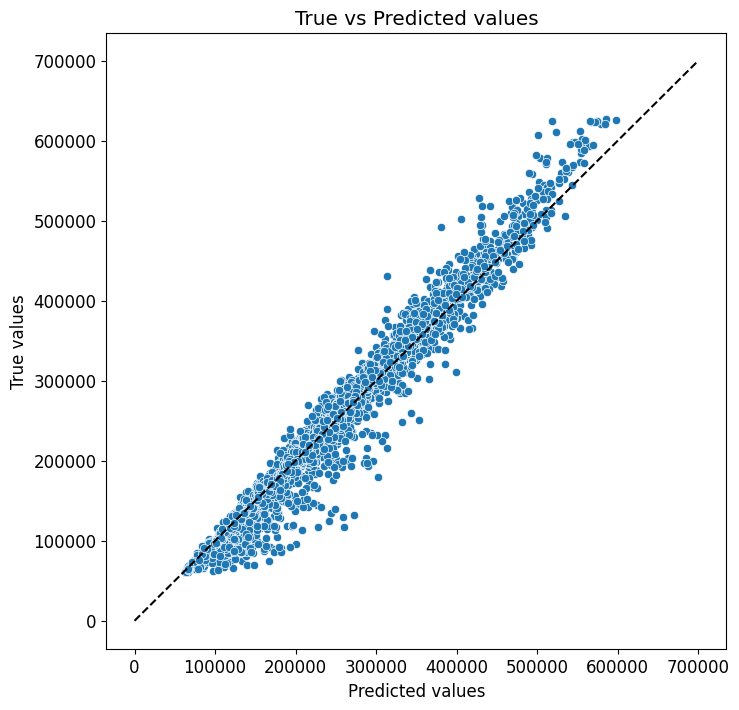

In [242]:
rf_model = RandomForestRegressor(criterion='friedman_mse',
                                # max_depth=20, # глубина дерева
                                # min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                # n_estimators=100,  # кол-во деревьев
                                 random_state=42
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.768
RMSE:	43968.268
MSE:	1933208601.046


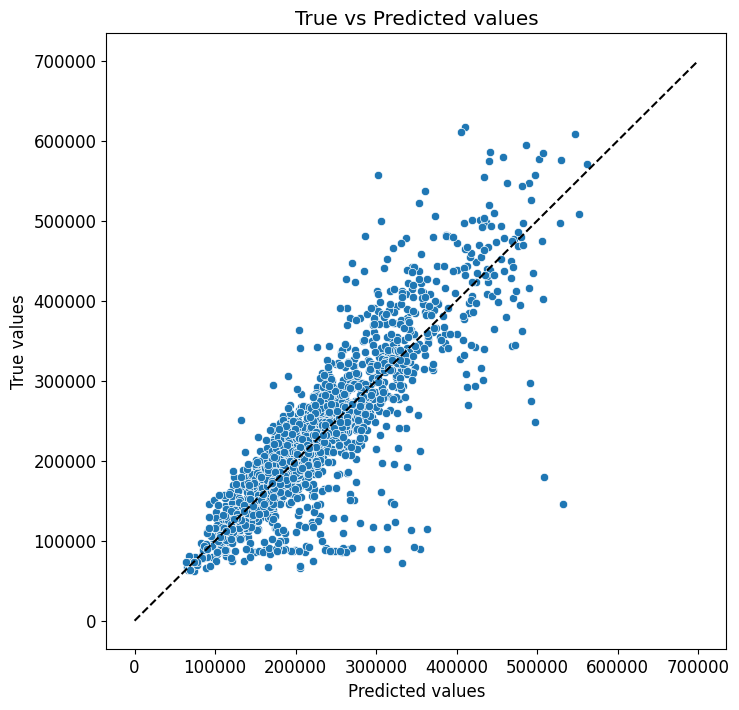

In [243]:
y_valid_preds_rf = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds_rf)

Советовали не включать в итоговую работу подбор параметров по сетке, потому закомменирую.

In [244]:
# %%time
# params = {'max_depth':[29, 30, 31],
#           'min_samples_leaf':[2, 3, 4],
#           'n_estimators':[400, 410, 420, 430]}

# gs = GridSearchCV(rf_model, params,
#                   scoring='r2', # метрика
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=42,
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

In [245]:
# res = pd.DataFrame(gs.cv_results_)
# res.sort_values('rank_test_score').head()

In [246]:
# gs.best_params_

In [247]:
# gs.best_score_

### Модель на лучших параметрах

R2:	0.927
RMSE:	24652.312
MSE:	607736493.282


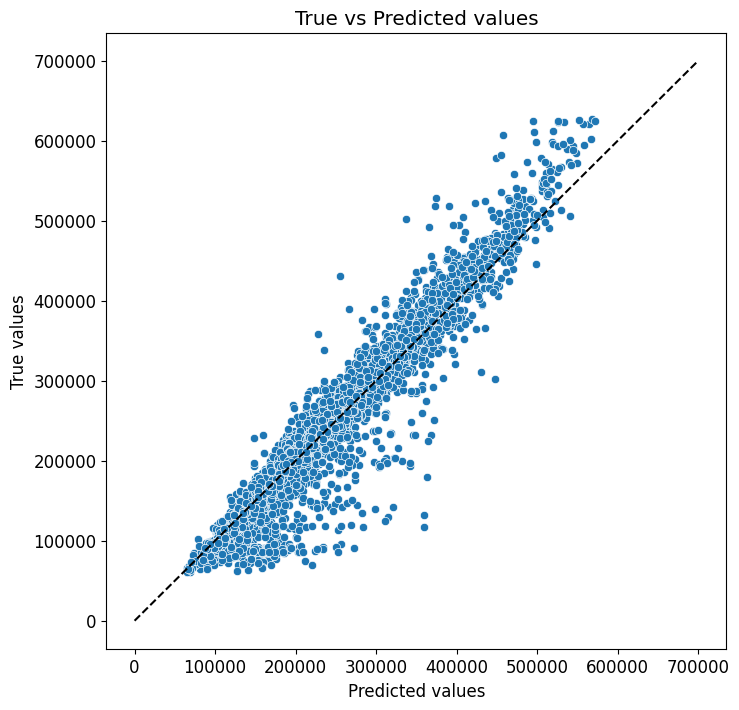

In [248]:
rf_best_model = RandomForestRegressor(criterion='poisson',
                                 max_depth=29, # глубина дерева
                                 min_samples_leaf=3, # минимальное кол-во наблюдений в листе дерева
                                 n_estimators=420,  # кол-во деревьев
                                 random_state=42
                                 )

rf_best_model.fit(X_train, y_train)
y_train_preds = rf_best_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.773
RMSE:	43427.156
MSE:	1885917900.23


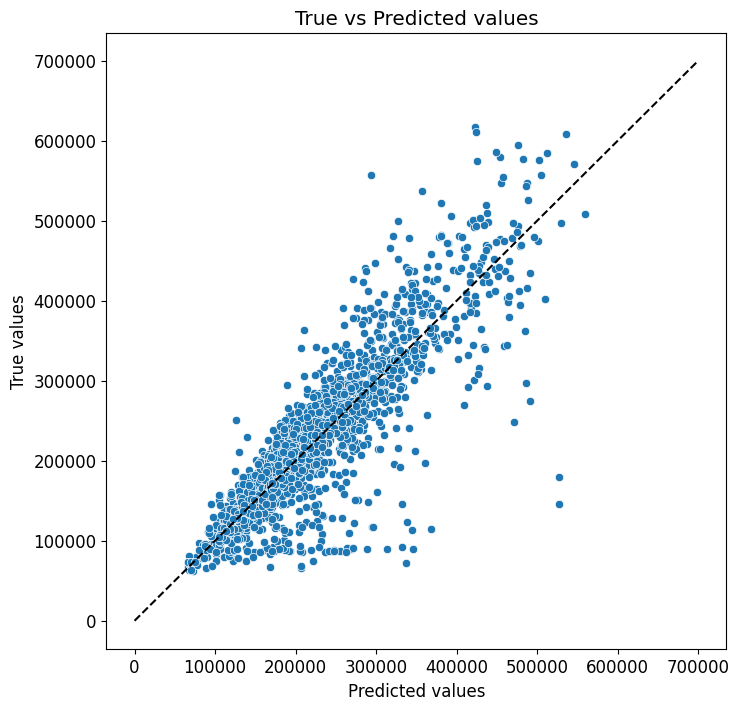

In [249]:
y_valid_preds_rf = rf_best_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds_rf)

Советовали не применять градиентный бустинг, но он всё же немного точнее предсказывает, потому всё же остановимся на нём.

### Gradient Boosting decision trees

In [250]:
gb_model = GradientBoostingRegressor(criterion='friedman_mse',
                                     max_depth=7, # макс глубина
                                     min_samples_leaf=10, # минимальное кол-во наблюдений в листе дерева
                                     n_estimators=100, # кол-во моделей / кол-во деревьев
                                     random_state=42
                                     )

R2:	0.917
RMSE:	26251.617
MSE:	689147413.887


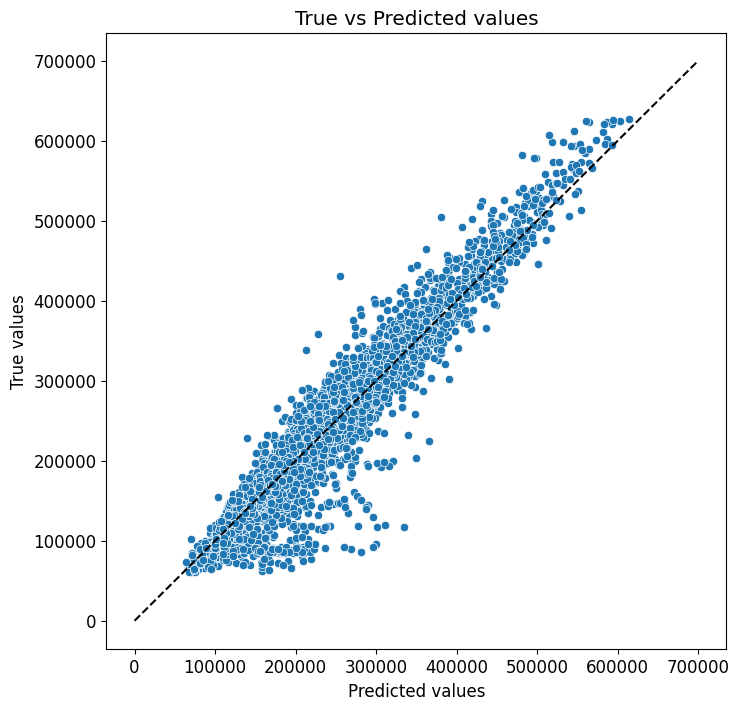

In [251]:
gb_model.fit(X_train, y_train)
y_train_preds_gb = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds_gb)

R2:	0.773
RMSE:	43462.492
MSE:	1888988174.723


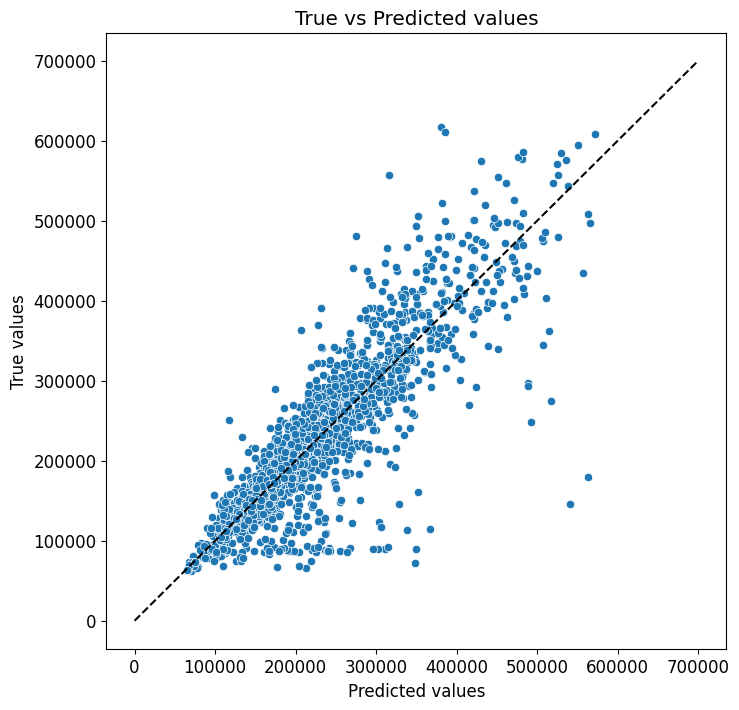

In [252]:
y_valid_preds_gb = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds_gb)

### КРОСС-ВАЛИДАЦИЯ поиск по сетке параметров

Советовали не включать в итоговую работу подбор параметров по сетке, потому закомменирую.

In [253]:
# %%time
# params = {'max_depth':[4],
#           'min_samples_leaf':[5],
#           'n_estimators':[250]}

# gs = GridSearchCV(gb_model, params,
#                   scoring='r2', # метрика
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=42,
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

In [254]:
# res = pd.DataFrame(gs.cv_results_)
# res.sort_values('rank_test_score').head()

In [255]:
# gs.best_params_

In [256]:
# gs.best_score_

### Градиентный бустинг на лучших параметрах

R2:	0.884
RMSE:	31059.744
MSE:	964707727.93


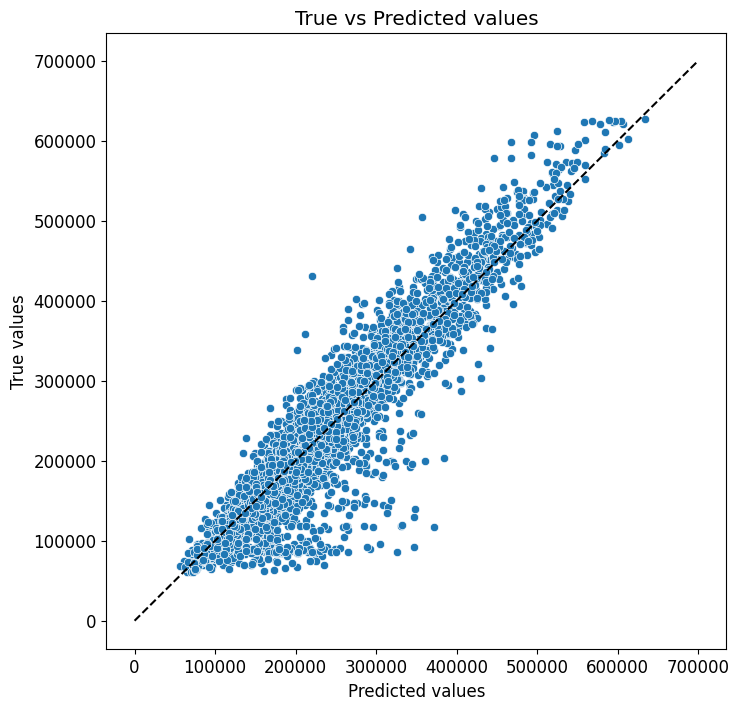

In [257]:
gb_best_model = GradientBoostingRegressor(criterion='friedman_mse',
                                          max_depth=4, # макс глубина
                                          min_samples_leaf=5, # минимальное кол-во наблюдений в листе дерева
                                          n_estimators=250, # кол-во моделей / кол-во деревьев
                                          random_state=42
                                          )

gb_best_model.fit(X_train, y_train)
y_train_preds_gb_best = gb_best_model.predict(X_train)
evaluate_preds(y_train, y_train_preds_gb_best)

R2:	0.776
RMSE:	43183.842
MSE:	1864844167.145


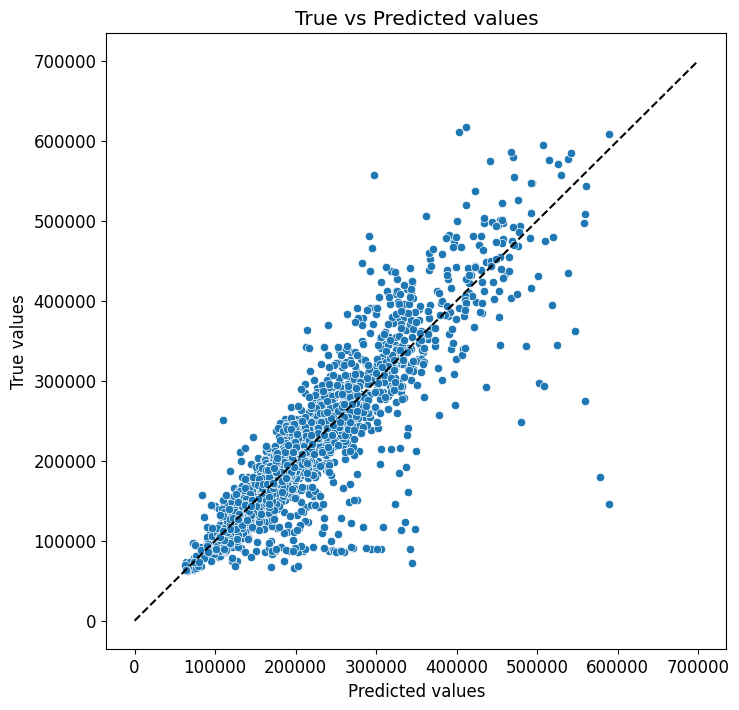

In [258]:
y_valid_preds_gb = gb_best_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds_gb)

### Прогнозирование на тестовом датасете

Объединим тестовый и валидационный датасеты и проведём тренировку на полном датасете

In [259]:
X_train_o = pd.concat([X_train, X_valid])
y_train_o = pd.concat([y_train, y_valid])
gb_best_model.fit(X_train_o, y_train_o)

GradientBoostingRegressor(max_depth=4, min_samples_leaf=5, n_estimators=250,
                          random_state=42)

In [260]:
y_test_preds_gb_best = gb_best_model.predict(test_df)

In [261]:
y_test_preds_gb_best

array([156779.86778409, 193326.6065988 , 106846.96921005, ...,
       337897.49184917, 197724.42696496, 183507.57924247])

In [262]:
submit['Price'] = y_test_preds_gb_best

In [263]:
submit

,Id,Price
0,725,156779.867784
1,15856,193326.606599
2,5480,106846.969210
3,15664,352882.626044
4,14275,136929.600791
...,...,...
4995,8180,234235.127243
4996,4695,140641.110362
4997,5783,337897.491849
4998,4780,197724.426965


In [264]:
submit.to_csv('AGrigorkin_predictions.csv', index=False)

### Анализ прогнозов

#### **Важность признаков**

In [265]:
gb_best_model.feature_importances_

array([2.21904462e-02, 4.94123167e-01, 1.05279364e-02, 8.23894092e-03,
       7.74249017e-03, 1.59964560e-02, 2.13860491e-02, 7.69554521e-03,
       0.00000000e+00, 3.18600524e-04, 7.40992541e-03, 1.06634301e-02,
       5.80217347e-03, 2.43672480e-03, 3.38928214e-03, 7.94055629e-05,
       6.37163373e-04, 7.08000374e-03, 3.74282260e-01])

In [266]:
feature_importances = pd.DataFrame(zip(X_train.columns,
                                       gb_best_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [267]:
feature_importances

,feature_name,importance
1,Square,0.494123
18,MedPriceM2ByDistrict,0.374282
0,Rooms,0.022190
6,HouseYear,0.021386
5,HouseFloor,0.015996
11,Social_2,0.010663
2,LifeSquare,0.010528
3,KitchenSquare,0.008239
4,Floor,0.007742
7,Ecology_1,0.007696


Наиболее значимые признаки - полщадь квартиры и средняя цена за квадратный метр в округе.

Оставим только признаки с влиянием более 1 %.

In [268]:
need_feature_names = list(feature_importances[:7]['feature_name'])

In [269]:
need_feature_names

['Square',
 'MedPriceM2ByDistrict',
 'Rooms',
 'HouseYear',
 'HouseFloor',
 'Social_2',
 'LifeSquare']

In [270]:
X_train = X_train[need_feature_names]
X_valid = X_valid[need_feature_names]
test_df = test_df[need_feature_names]

R2:	0.87
RMSE:	32911.478
MSE:	1083165392.029


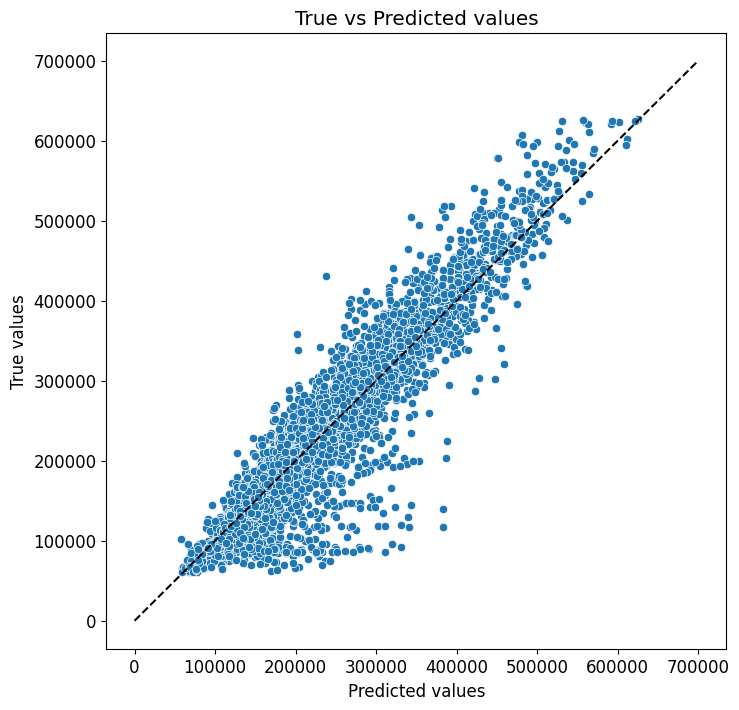

In [271]:
gb_best_model.fit(X_train, y_train)
y_train_preds_gb_best = gb_best_model.predict(X_train)
evaluate_preds(y_train, y_train_preds_gb_best)

R2:	0.773
RMSE:	43439.721
MSE:	1887009327.965


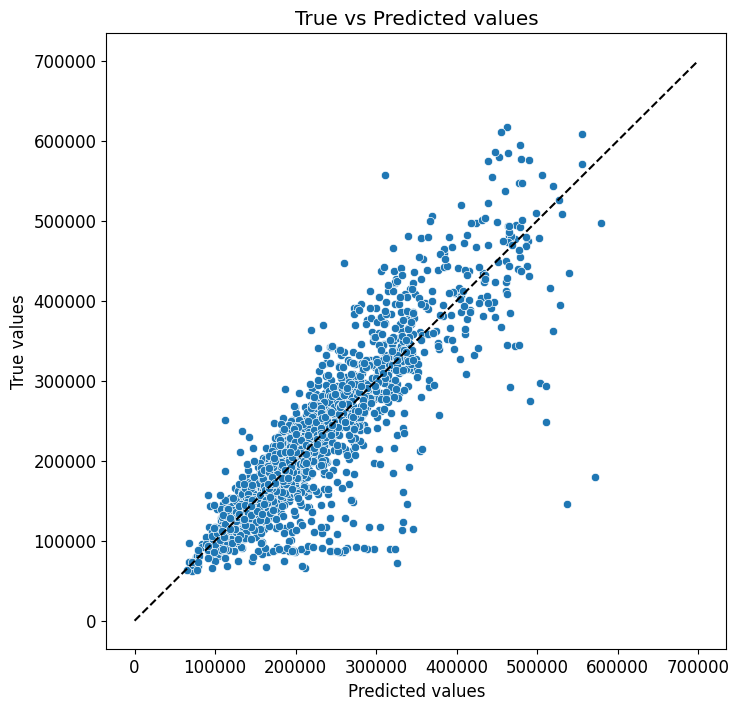

In [272]:
y_valid_preds_gb = gb_best_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds_gb)

Точность предсказания уменьшилась меньше, чем на 0.5 %

In [281]:
R2_gb=0.776
R2_gb_7=0.773
drop_in_accuracy = (1-R2_gb_7/R2_gb)*100
drop_in_accuracy

0.3865979381443285

In [274]:
gb_best_model.feature_importances_
feature_importances = pd.DataFrame(zip(X_train.columns,
                                       gb_best_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
0,Square,0.500959
1,MedPriceM2ByDistrict,0.385459
3,HouseYear,0.028769
5,Social_2,0.025720
2,Rooms,0.023284
4,HouseFloor,0.018114
6,LifeSquare,0.017695


А оставив только два самых значимых признака:

In [275]:
need_feature_names = list(feature_importances[:2]['feature_name'])
X_train = X_train[need_feature_names]
X_valid = X_valid[need_feature_names]
test_df = test_df[need_feature_names]

R2:	0.814
RMSE:	39399.144
MSE:	1552292586.788


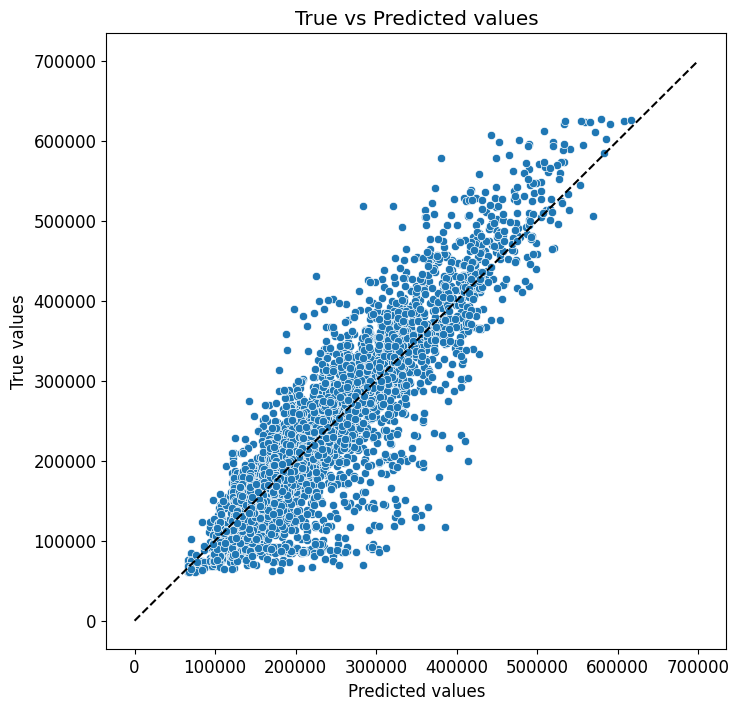

In [276]:
gb_best_model.fit(X_train, y_train)
y_train_preds_gb_best = gb_best_model.predict(X_train)
evaluate_preds(y_train, y_train_preds_gb_best)

R2:	0.734
RMSE:	47065.444
MSE:	2215156002.788


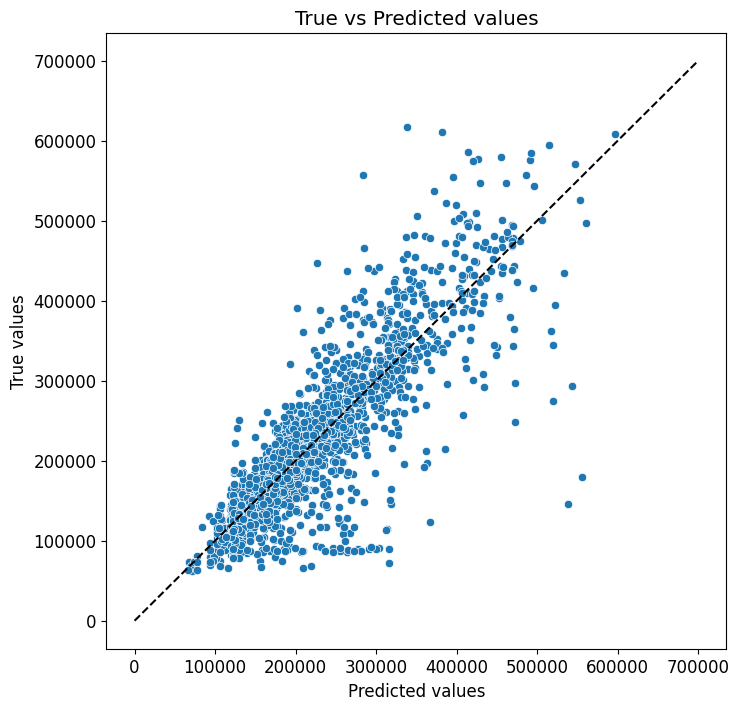

In [277]:
y_valid_preds_gb = gb_best_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds_gb)

In [278]:
R2_gb_2=0.734
drop_in_accuracy = (1-R2_gb_2/R2_gb)*100
drop_in_accuracy

5.4123711340206215

Точность предсказания всего на двух признаках падает всего на 5,4%.